# Application of Gradient Boosting for Virtual Flow Metreing

## 1. Introduction

A single oil and gas field produces an enormous amount of data every day. With the increasing popularity of _machine learning_, the potential of utilizing these data to produce a value for the industry is also increasing. One way of utilizing the data is to __estimate/monitor oil, gas and water flowrates__ from a well or a cluster of wells. Predicting or measuring oil, gas and water flowrates is an important point in operation of oil and gas production systems because it allows to monitor field behavior in real time which in turn allows to improve oil recovery from a reservoir and optimize long and short term production. 

There are different ways to estimate/measure the oil production. One way of doing this is to install a multiphase flow meter (MPFM) (https://en.wikipedia.org/wiki/Multiphase_flow_meter) for each well which  is in general capable to measure the flowrates of a multiphase flow mixture in real time. The main disadvantage of this approach is that MPFMs are expensive. Another approach is to make a model of a system (using knowledge of multiphase flow physics or data) and then predict the flow using this model. This approach is called __Virtual Flow Metering__. Sometimes, these approaches are used together for redundancy and cross-monitoring.

In this project, a machine learning algorithm - __Gradient Boosting with XGBoost implementation__ - is tested in performing oil rate prediction for a well with and without a multiphase flow meter. More onformation on XGboost can be found in (https://xgboost.readthedocs.io/en/latest/).

This notebook is the skeleton of the IFAC paper __"Application of Gradient Boosting for Virtual Flow Metering"__ which can be found via this __link__: (to be updated when the paper available).


## 2. The system and data gathering

The system considered in this project is a subsea oil well which is linked with a production platform via a flowline, a riser and an inlet separator. In addition to pressure and temperature sensors, there is a multiphase flow meter installed at the wellhead which measures the flow in real time. The system can be seen in Fig.1. The system is modelled in __OLGA software__ which is a leading software for multiphase transport of oil and gas mixtures. __OLGA__ is linked with __MATLAB__ via __OPC client Matrkion__. When the sytem is modelled, the predictions from a multiphase flow meter (MPFM) are obtained with a certain accuracy. In reality, MPFM produced measurements of flows but as the entire system in this work is a model, we can asume a certain accuracy of the device and introduce it as an error with respect to the true rate. A more detailed description of the system modeling and calculating procedure for MPFM predictions can be found in the original paper (_to be updated when the paper available_)

__Available data:__
Often during production, a special operation called __Well test__ are performed in order to calibrate the MPFM. In this work we assume that well testes are performed every 6 months. 

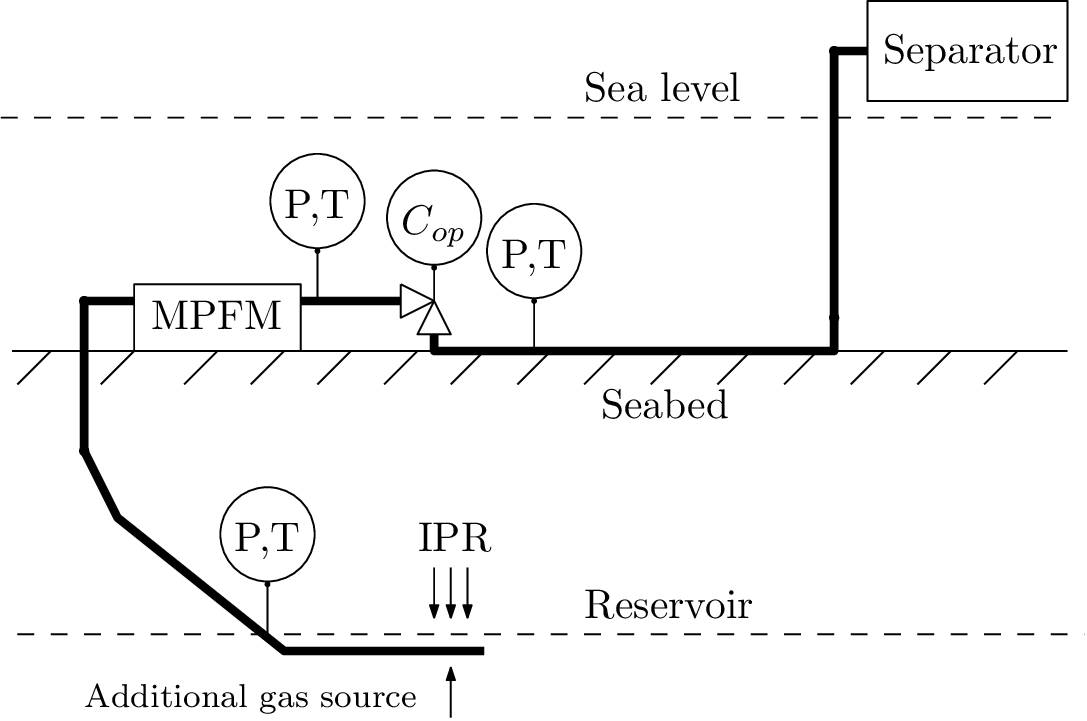

In [1]:
from IPython.display import Image, display
display(Image(filename='img/ProdSystem.jpg', width=400, height=400,  embed=True))

##### Fig.1 Oil production system used in the study

# 3. Case studies

### 3.1 Production data

The data are produced using the production system architecture shown in __Fig.1__. The performance of the system is simulated for a period of 2 years. Every __6 months__ we assume that well tests are performed. A __well test__ is an operation procedure when the well flowrate is monitored at the inlet separator with high accuracy under different conditions. In addition, fluid properties are estimated with a high accuracy which allows to calibrate MPFM. More information can be found on Wiki (https://en.wikipedia.org/wiki/Well_test_(oil_and_gas)

The simulated production profile without the well tests performance is shown in __Fig.2__. The period is divided into 4 parts (quarters) 180 days each. A __well test__ is conducted at the beginning of each quarter to obtain reliable information about the well performance. We collect the measurements every 8 hours during the normal production time and every 30 mins during the well tests.

For the algorithm training we get the following data __(features)__:
- P, T at well downhole
- P, T at wellhead before the choke valve
- P, T at wellhaed after the choke vale
- Choke valve opening ($C_{op}$)

The __target variable__ is then __oil flowrate__.

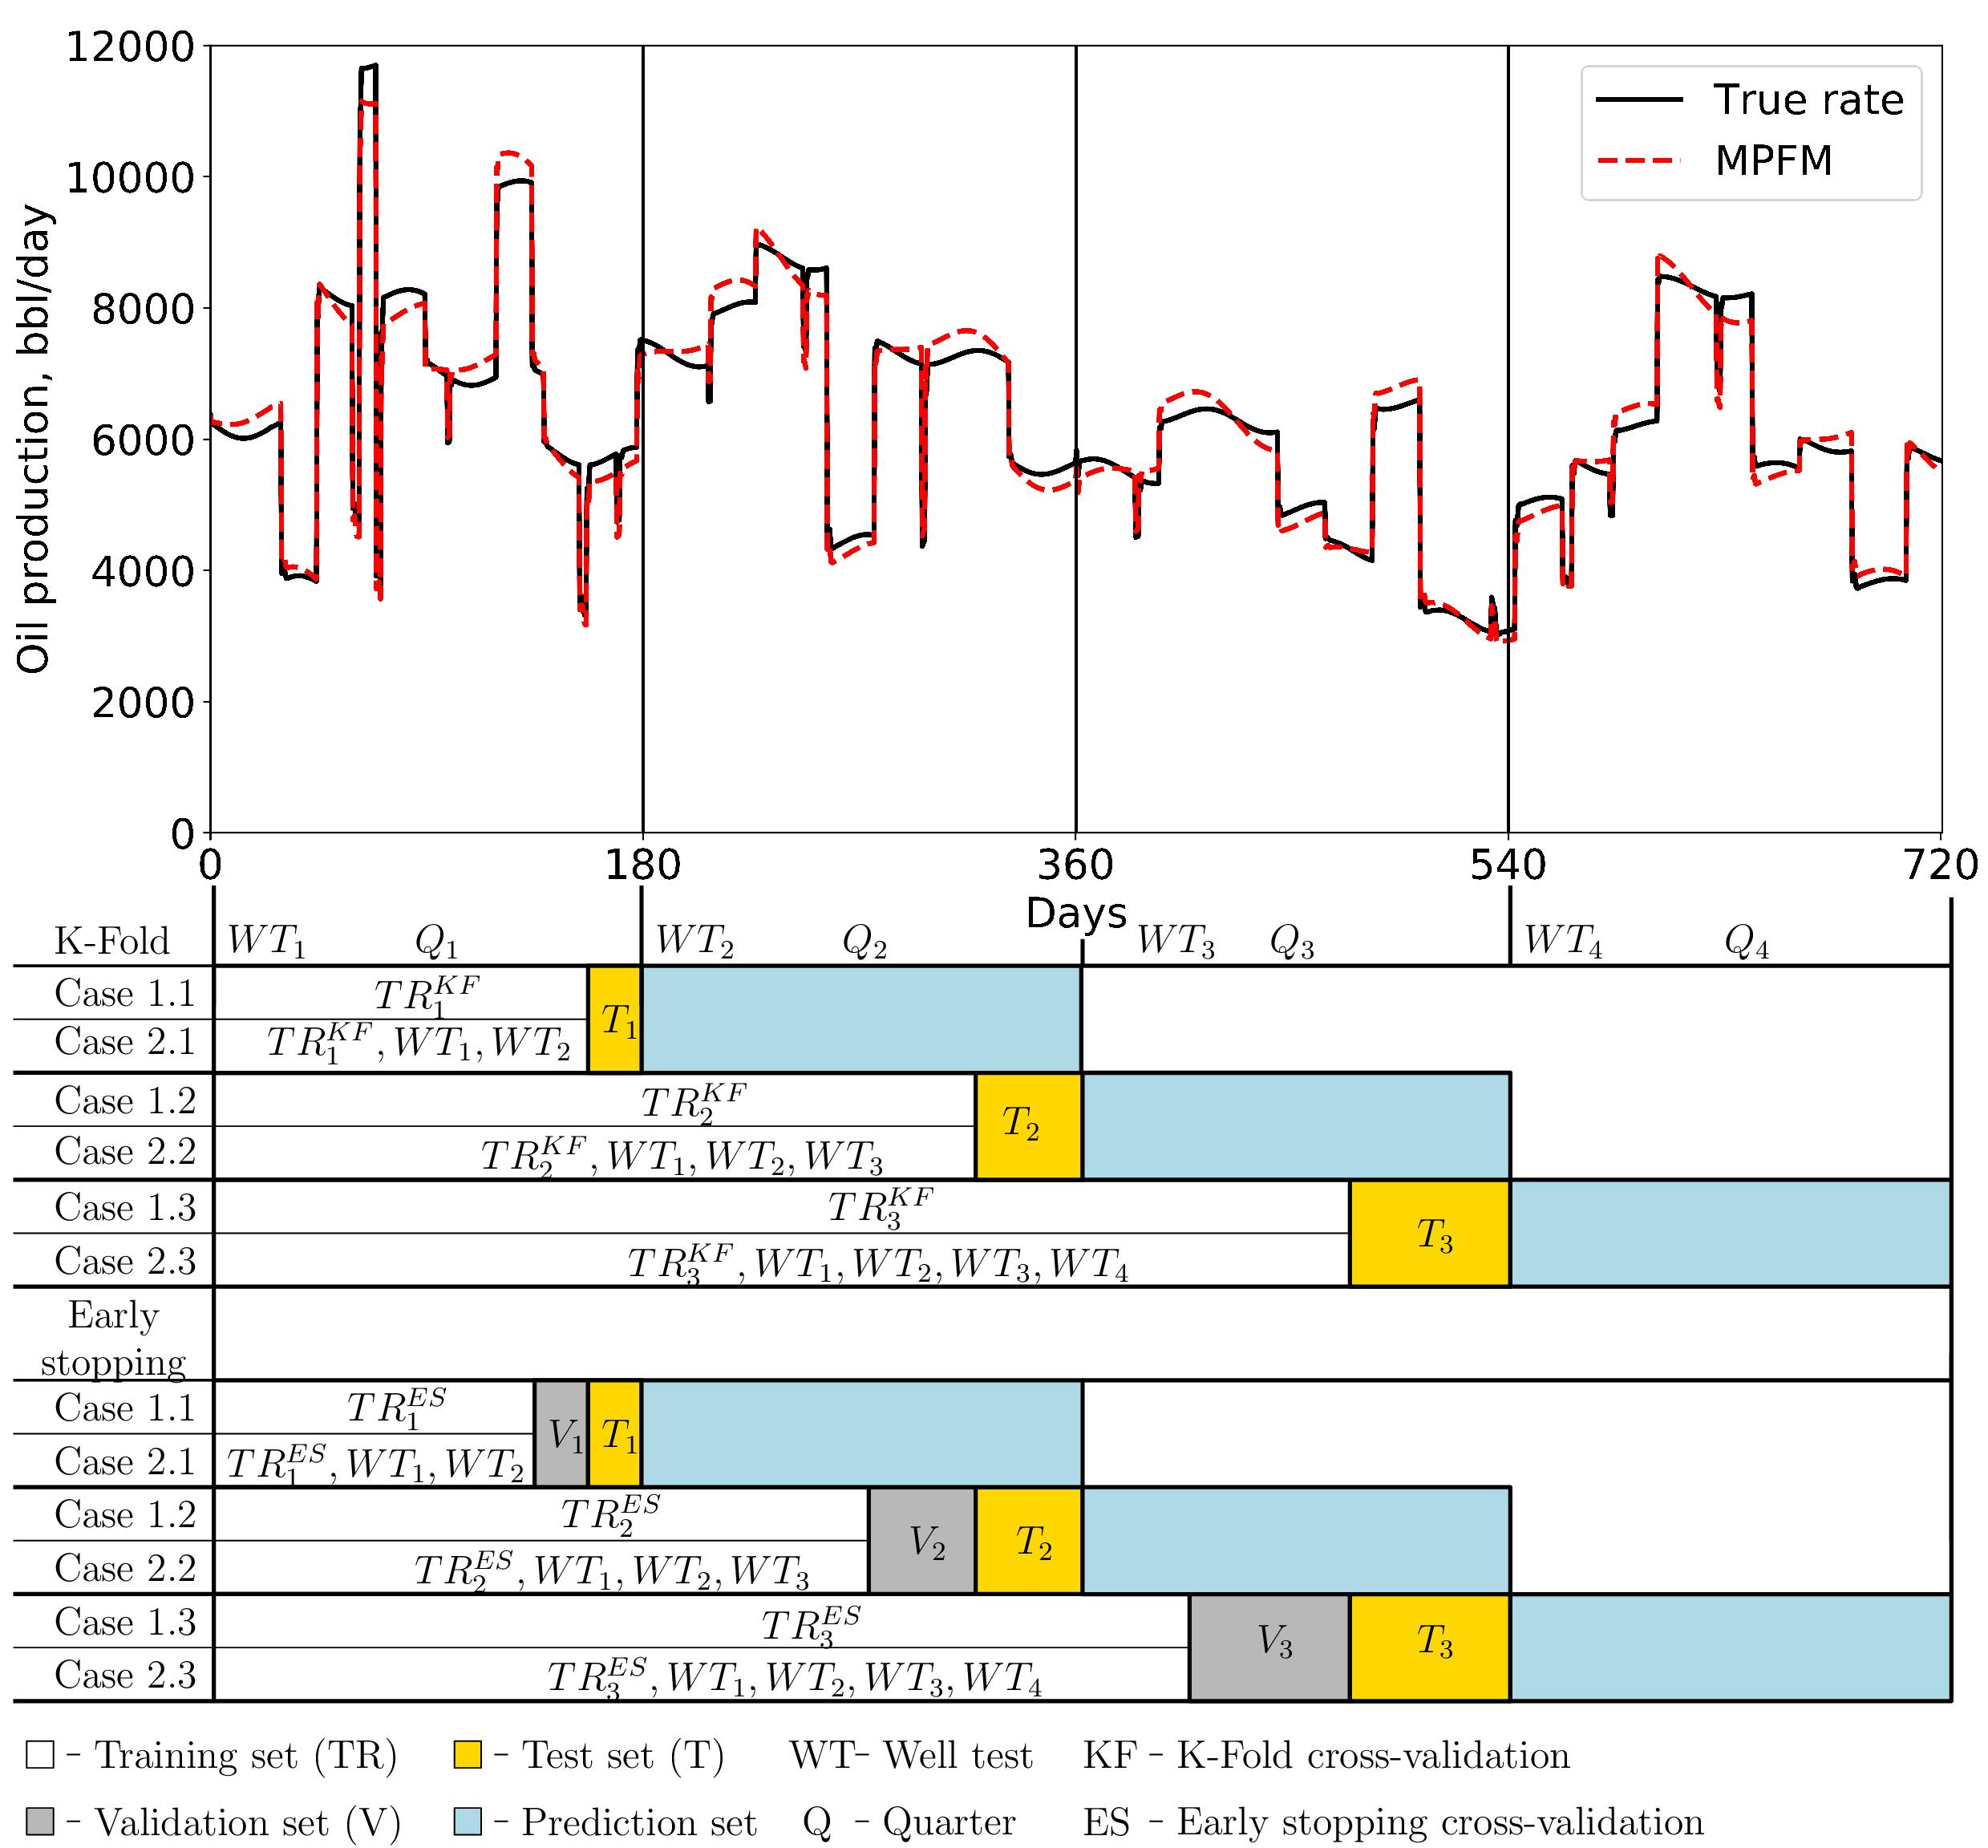

In [2]:
display(Image(filename='img/Profile.jpg', width=700, embed=True))

### Fig. 2 - Production profile with defined simulation cases and cross-validation schemes

### 3.2 Simulation approach

__For each case descibed below (Case 1, Case 2, Case 3) we perform 3 cases studies (subcases). This is done by extending the training datasets as the production time evolves. The more detailed description is shown in Fig. 2__

__Example: in Case 1.1 the data from the first half a year is available for training ($Q_1$ in Fig.2) and we predict the flowrates for $Q_2$. In Case 1.2, with more training data, the data from $Q_1$ and $Q_2$ are for training and testing the model and perform predictions on $Q_3$.__

### 3.3 Case 1 - MPFM data

In this case, we make an assumption that we do not have information from the well tests which can be the case when well testing is expensive. Then for the target variable we use the flowrate measurements from the MPFM only.

### 3.4 Case 2 - MPFM + Well tests data

In this case, we combine the well tests and MPFM data for training. This is often the case because well tests can be conducted to calibrate these MPFMs as well as update information about the reservoir.

### 3.5 Case 3 - Well test data

When installing MPFMs is very expensive and unfeasible, we would need to rely on well test data only. This case considers this situation.

### 3.6 Validation schemes

For each case we perform two differnt validation strategies: cross-validation and early stopping. As the problem is time dependent, it must be considered as time series problem. Then, K-Fold cross validation must be conducted in a nested manner. The __nested cross-validation__ scheme used in this study is shown in __Fig.3.__. For both schemes, 15% of the available training data are used ofr testing. For early stopping, additional 15% is dedicated for the validation dataset. 

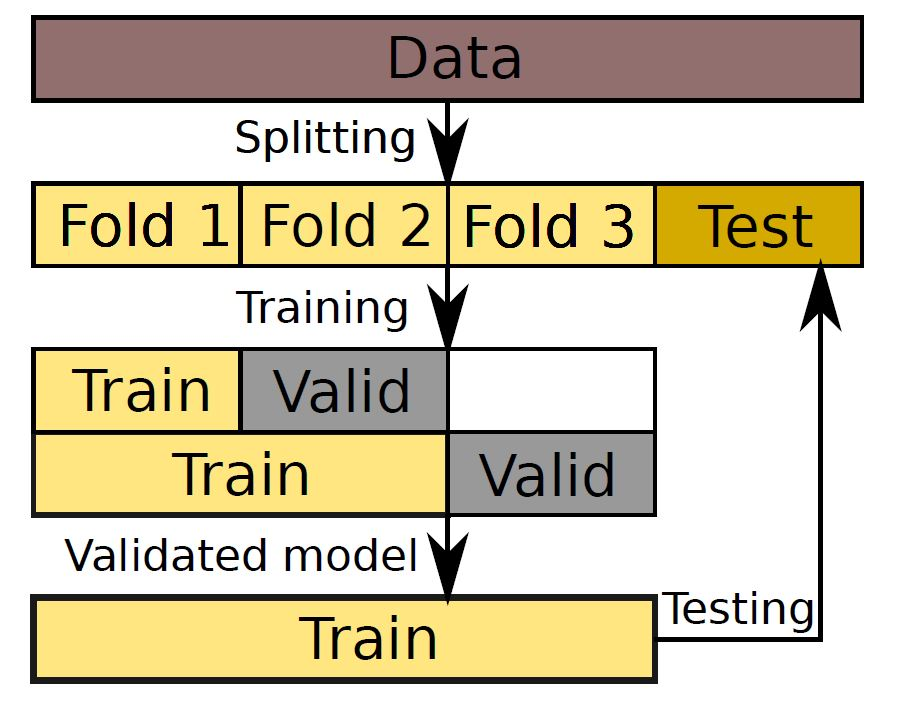

In [3]:
display(Image(filename='img/NestedCV.jpg', width=400, embed=True))

### Fig. 3 - Nested cross-validation scheme  used in the study

# 4. Simulation part

Import the nessary packages

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.stats as st
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, TimeSeriesSplit
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from xgboost import plot_importance
from sklearn.model_selection import ParameterSampler
from IPython.display import Image, display, HTML

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true)))*100

## 4.1 Data pre-processing

### Reading the data (MATLAB files)

The data used for machine learning study is stored in MATLAB files. The well test data are stored in a separate file

In [6]:
data_mat = scipy.io.loadmat('Boosting_data_11.mat') #Oil production data
data_mat_test = scipy.io.loadmat('Boosting_data_11_test.mat') #Oil well test data

### Form the data set with all the data from "_data mat_" file

In [7]:
#Names of the variables contained in the data
names = ['oil_rate_meter', 'gas_rate', 'gas_rate_meter', 'choke_opening', 'P_WF', 'T_WF', 'P_WHCU', 
        'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 'T_riser']
#Start forming the dataset from the .mat file
data = pd.DataFrame(data_mat['oil_rate_bbl'])
#Append the data into data frame from the MATLAB file
for name in names:
    data = pd.concat([data, pd.DataFrame(data_mat[name])], axis = 1, ignore_index = True)
data = pd.DataFrame(data.values, columns = ['oil_rate_bbl', 'oil_rate_meter', 'gas_rate', 
                                            'gas_rate_meter', 'choke_opening', 'P_WF', 'T_WF', 
                                            'P_WHCU', 'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 
                                            'T_riser'])

#Form the features dataset. Drop the target variables and P, T riser (possible to include later 
#to see if it helps to make better predictions)
X = data.drop(columns = ['oil_rate_bbl', 'oil_rate_meter', 'gas_rate', 'gas_rate_meter', 
                         'P_riser', 'T_riser'], inplace = False)

#Data for multiphase flow meter - flowrate measured by the multiphase flow meter
y_meter = pd.DataFrame(data[['oil_rate_meter']])
y_meter.columns = ['oil_rate_bbl']

#Data for true production 
y_true = pd.DataFrame(data['oil_rate_bbl'])

### Splitting the data on quarters (6 months periods) which are used for predictions

In [8]:
#Indicies for splitting
total_index = X.shape[0]
index_1 = round(total_index * 0.25) #Quarter 1
index_2 = round(total_index * 0.5) #Quarter 2
index_3 = round(total_index * 0.75) #Quarter 3

#Quarter 1
X_1, y_1, y_1_true, y_1_meter = X.iloc[:index_1, :], y_meter.iloc[:index_1], y_true.iloc[:index_1], y_meter.iloc[:index_1]
#Quarter 2
X_2, y_2, y_2_true, y_2_meter = X.iloc[index_1 : index_2, :], y_meter.iloc[index_1 : index_2], y_true.iloc[index_1 : index_2], y_meter.iloc[index_1 : index_2]
#Quarter 3
X_3, y_3, y_3_true, y_3_meter = X.iloc[index_2 : index_3, :], y_meter.iloc[index_2 : index_3], y_true.iloc[index_2 : index_3], y_meter.iloc[index_2 : index_3]
#Quarter 4
X_4, y_4, y_4_true, y_4_meter = X.iloc[index_3 : , :], y_meter.iloc[index_3 :], y_true.iloc[index_3 :], y_meter.iloc[index_3 :]

### Form the well test data from _"data mat test"_ file

In [9]:
#First, read the data of the choke position because it has different shape from other data
choke_test = np.array(data_mat_test['choke_test']) #Read the choke data
choke_test = choke_test.reshape((-1, 1), order = 'F') #Reshape it on the vector
#Copy the choke array because there were 4 well tests
choke_test = pd.DataFrame(np.tile(choke_test, (4, 1)), columns = ['choke_opening'])


#Names of the variables contained in the data from well tests
names = ['gas_rate_test', 'choke_test', 'P_WF_test', 'T_WF_test', 'P_WHCU_test', 
         'T_WHCU_test', 'P_WHCD_test', 'T_WHCD_test', 'P_riser_test', 'T_riser_test']

#Start forming the dataset from the .mat file
data_test = pd.DataFrame(data_mat_test['oil_rate_bbl_test'])
#Remove zeros because zeros here indicates the data when there is no well test(normal production)
data_test = data_test[(data_test.T != 0).any()]
data_test.reset_index(drop = True, inplace = True)

#Append the data into data frame from the MATLAB file
for name in names:
    if name == 'choke_test':
        #Concatenate the data of choke openings (zeros are droped already)
        data_test = pd.concat([data_test, choke_test], axis = 1, ignore_index=True)
    else:
        #Drop zeros again where there is no well test
        drop_zeros = pd.DataFrame(data_mat_test[name][data_mat_test[name] != 0])
        drop_zeros.reset_index(drop = True, inplace = True)
        #Concatenate with the rest of the data
        data_test = pd.concat([data_test, drop_zeros], axis = 1, ignore_index=True)
        
data_test = pd.DataFrame(data_test.values, columns = ['oil_rate_bbl', 'gas_rate', 'choke_opening',                                                      'P_WF', 'T_WF', 
                                                      'P_WHCU', 'T_WHCU', 'P_WHCD','T_WHCD', 
                                                      'P_riser', 'T_riser'])

#Form the features dataset. Drop the target variables and P, T riser
X_well_test = data_test.drop(columns = ['oil_rate_bbl', 'gas_rate', 'P_riser',
                                        'T_riser'], inplace = False)
y_well_test = data_test[['oil_rate_bbl']]

### Choke opening profile used in well tests

In this work we propose to perform the well test in a step wise manner over the possible choke opening range. In addition, some other points around the potential operation point can be tested. The proposed choke opening profile for well testing is shown in Fig.4

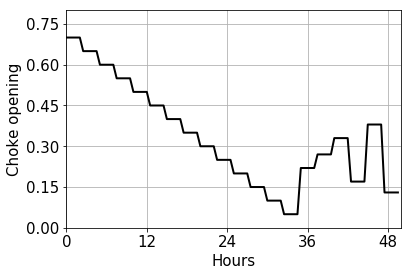

In [10]:
#Plot the choke opening
ax = plt.subplot(1, 1, 1)
ax.plot(X_well_test['choke_opening'][:100], linewidth = 2, color = 'k')
ax.set_xlabel('Hours', size = 15) #X-label definition
ax.set_xlim(0, 100) #Limit of x
ax.set_ylim(0, 0.8) #Limit of y
ax.set_ylabel('Choke opening', size = 15) #y-label
#Change the values of ticks to make it in hours because every second point correspond to 1 hour
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.15))                   
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
x_values = [0, 0,  12, 24, 36, 48]
plt.gca().xaxis.set_ticklabels(x_values, size = 15)

#y-axis
ax.set_ylabel('Choke opening', size = 15)
ax.yaxis.set_tick_params(labelsize = 15)
ax.grid()

#Line for saving the figure
#plt.savefig('Choke.eps', dpi=1000, format='eps')

### Fig.4 - Choke opening profile proposed for well testing

### Split the well test data in 4 parts, so that each part correspond to 1 well test

In [11]:
#Splitting the well test data based on when the tests were made
total_index = X_well_test.shape[0]
index_1 = round(total_index * 0.25) #Well test 1 index
index_2 = round(total_index * 0.5)  #Well test 2 index
index_3 = round(total_index * 0.75)  #Well test 3 index

#Split the data into well tests according to indicies
X_1_well_test, y_1_well_test = X_well_test.iloc[:index_1, :], y_well_test.iloc[:index_1 ]
X_2_well_test, y_2_well_test = X_well_test.iloc[index_1 : index_2, :], y_well_test.iloc[index_1 : index_2]
X_3_well_test, y_3_well_test = X_well_test.iloc[index_2 : index_3, :], y_well_test.iloc[index_2 : index_3]
X_4_well_test, y_4_well_test = X_well_test.iloc[index_3 : , :], y_well_test.iloc[index_3 :]

### Organizing datasets for training according to case studies

We need to form the datasets for each case study by splitting/mearging the datasets of production and well tests. Moreover, we need to allocate an additional part of dataset for validation part of __early-stopping__.

#### Case 1 - MPFM data

In this case we use the data only from the multiphase flow meter

In [12]:
#X_1 - features dataset from production
#y_1 - measurements from the multiphase flow meter
#Case 1.1
X_1_set = X_1 #Not neccesary but writen for consistency with further manipulations
y_1_set = y_1 #Not neccesary but writen for consistency with further manipulations
#Cut 30% for validation + test in early stopping, the 15% for validation only
X_1_ES, X_1_val, y_1_ES, y_1_val = train_test_split(X_1_set, y_1_set, \
                                                    test_size = 0.30, shuffle = False)
X_1_val, X_1_test, y_1_val, y_1_test = train_test_split(X_1_val, y_1_val, \
                                                        test_size = 0.50, shuffle = False)
#Include early-stopping validation set back for K-Fold validation procedure 
X_1_CV = pd.concat([X_1_ES, X_1_val], axis = 0, ignore_index = True)
y_1_CV = pd.concat([y_1_ES, y_1_val], axis = 0, ignore_index = True)


#Case 1.2
#Now we combine the data from 1st and 2nd quarters for training. The rest procedure is the same
X_2_set =  pd.concat([X_1, X_2], axis = 0, ignore_index = True) #Combine the sets
y_2_set = pd.concat([y_1, y_2], axis = 0, ignore_index = True)  #Combine the sets
#Early-stopping datasets
X_2_ES, X_2_val, y_2_ES, y_2_val = train_test_split(X_2_set, y_2_set, \
                                                    test_size = 0.30, shuffle = False)
X_2_val, X_2_test, y_2_val, y_2_test = train_test_split(X_2_val, y_2_val, \
                                                        test_size = 0.50, shuffle = False)
#K-Fold validation datasets
X_2_CV = pd.concat([X_2_ES, X_2_val], axis = 0, ignore_index = True)
y_2_CV = pd.concat([y_2_ES, y_2_val], axis = 0, ignore_index = True)


#Case 1.3
#Now we combine the data from 1st, 2nd and 3rd quarters for training.
X_3_set =  pd.concat([X_1, X_2, X_3], axis = 0, ignore_index = True)#Combine the data
y_3_set = pd.concat([y_1, y_2, y_3], axis = 0, ignore_index = True) #Combine the data
#Early-stopping sets
X_3_ES, X_3_val, y_3_ES, y_3_val = train_test_split(X_3_set, y_3_set, \
                                                    test_size = 0.30, shuffle = False)
X_3_val, X_3_test, y_3_val, y_3_test = train_test_split(X_3_val, y_3_val, \
                                                        test_size = 0.50, shuffle = False)
#K-Fold validation sets
X_3_CV = pd.concat([X_3_ES, X_3_val], axis = 0, ignore_index = True)
y_3_CV = pd.concat([y_3_ES, y_3_val], axis = 0, ignore_index = True)

#### Case 2 - MPFM + Well tests data

In this case we need to combine the datasets of production data and well test. Each well test is followed by the correspnding quarter of production data. So, for traing in 1st quarter we use the data from well test 1, 1st quarter production and well test 2. The scheme can be seen in __Fig.2__.

In [13]:
###################################### Case 2.1 ###########################################
#K-fold validation data
X_1_CV_2 = pd.concat([X_1_well_test, X_1_CV, X_2_well_test], axis = 0, ignore_index = True)
y_1_CV_2 = pd.concat([y_1_well_test, y_1_CV, y_2_well_test], axis = 0, ignore_index = True)
#Early-stopping data
X_1_ES_2 = pd.concat([X_1_well_test, X_1_ES, X_2_well_test], axis = 0, ignore_index = True)
y_1_ES_2 = pd.concat([y_1_well_test, y_1_ES, y_2_well_test], axis = 0, ignore_index = True)


####################################### Case 2.2 ###########################################
#Take 60% for testing from 2nd quarter to make it 30% after mearging with the 1st quarter
X_2_train, X_2_test_fake, y_2_train, y_2_test_fake = train_test_split(X_2, y_2, test_size = 0.60, \
                                                                      shuffle = False)
X_2_val_fake, X_2_test_fake, y_2_val_fake, y_2_test_fake = train_test_split(X_2_test_fake, \
                                                                            y_2_test_fake, \
                                                                            test_size = 0.50, \
                                                                            shuffle = False)
#Early-stopping data
X_2_ES_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2_train, X_3_well_test], axis = 0, \
                     ignore_index = True)
y_2_ES_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2_train, y_3_well_test], axis = 0, \
                     ignore_index = True)
#K-fold data
X_2_CV_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2_train, X_2_val_fake, X_3_well_test], \
                     axis = 0, ignore_index = True)
y_2_CV_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2_train, y_2_val_fake, y_3_well_test], \
                     axis = 0, ignore_index = True)


###################################### Case 2.3 ###########################################
#Take 90% for testing from 2nd quarter to make it 30% after mearging with the 1st and 2nd quarters
X_3_train, X_3_test_fake, y_3_train, y_3_test_fake = train_test_split(X_3, y_3, \
                                                                      test_size = 0.90, \
                                                                      shuffle = False)
X_3_val_fake, X_3_test_fake, y_3_val_fake, y_3_test_fake = train_test_split(X_3_test_fake, \
                                                                            y_3_test_fake, \
                                                                            test_size = 0.50, \
                                                                            shuffle = False)
#Early-stopping data
X_3_ES_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2, X_3_well_test, X_3_train, \
                      X_4_well_test], axis = 0, ignore_index = True)
y_3_ES_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2, y_3_well_test, y_3_train, \
                      y_4_well_test], axis = 0, ignore_index = True)
#K-fold data
X_3_CV_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2, X_3_well_test, X_3_train, \
                      X_3_val_fake, X_4_well_test], axis = 0, ignore_index = True)
y_3_CV_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2, y_3_well_test, y_3_train, \
                      y_3_val_fake, y_4_well_test], axis = 0, ignore_index = True)

#### Case 3 - Well test data only

Here we use the well test data only for training. We do not validation the model in this case, so that there is not a split for early-stopping and K-fold validation

In [14]:
#Case 3.1
X_1_train, y_1_train = X_1_well_test, y_1_well_test
#Case 3.2
X_2_train, y_2_train = pd.concat([X_1_well_test, X_2_well_test], axis = 0), \
pd.concat([y_1_well_test, y_2_well_test], axis = 0)
#Case 3.3
X_3_train, y_3_train = pd.concat([X_1_well_test, X_2_well_test, X_3_well_test], axis = 0), \
pd.concat([y_1_well_test, y_2_well_test, y_3_well_test], axis = 0)
#Case 3.4
X_4_train, y_4_train = pd.concat([X_1_well_test, X_2_well_test, X_3_well_test, \
                                  X_4_well_test], axis = 0), \
pd.concat([y_1_well_test, y_2_well_test, y_3_well_test, y_4_well_test], axis = 0)

### Plotting the data

As there are many data manipulations, it is a good practice to visualize the data to make sure that the manipulations are done correctly

__True rate oil production combined with well test data__
Here we combine all the data from production and well tests in a sequational way to understand how the acutual profile looks together with well tests.

Text(0.5, 1.0, 'Oil rate during production and well tests')

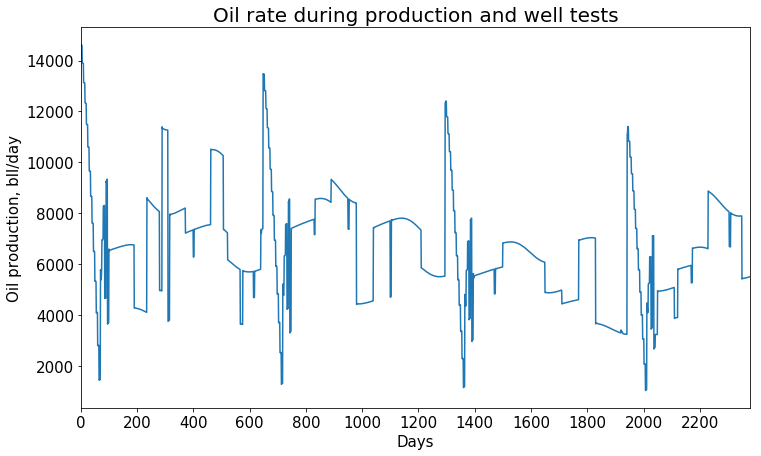

In [15]:
#Concatenate the data sequantially
y_total = np.concatenate((y_1_well_test, y_1, y_2_well_test, y_2, y_3_well_test, \
                          y_3, y_4_well_test, y_4), axis = 0)
#Plot the data
plt.figure(figsize = (12, 7))
plt.plot(y_total, label = 'Oil rate')
plt.xlabel('Days', size = 15)
plt.xticks(np.arange(0, 3000, step = 200), size = 15)
plt.ylabel('Oil production, bll/day', size = 15)
plt.yticks(size = 15)
plt.xlim(0, 2380)
plt.title('Oil rate during production and well tests', fontsize = 20)

### Comparison of true production profile and measurements from multiphase flow meter

As we introduced an error into multiphase flow meter measurements, it is also interesting to see the visualization of both the true production rate and multiphase flow meter predictions. This plot was already used in __Fig. 2__.

MAE error between the truth and MPFM is 202.9622523680088
MAPE error between the truth and MPFM is 3.1616898550705654


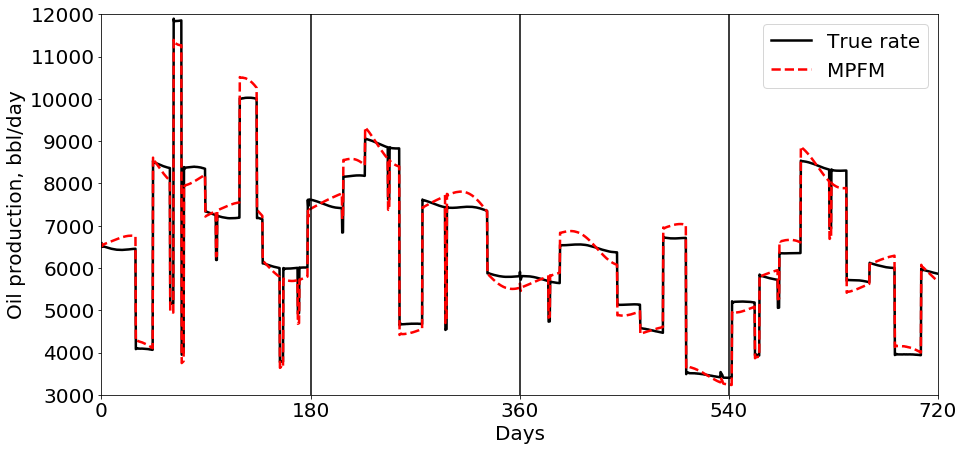

In [16]:
fig, ax = plt.subplots(figsize = (15, 7))

#Plot the true rate
ax.plot(data[['oil_rate_bbl']].values, label = 'True rate', linewidth = 2.5, color = 'k')
#Plot the rate from the multiphase flow meter
ax.plot(data[['oil_rate_meter']].values, label = 'MPFM', linewidth = 2.5, \
        linestyle = '--', color = 'r')
ax.legend(fontsize = 20)

#X-axis
ax.set_xlabel('Days', size = 20)
ax.set_xlim(0, 2190)
ax.xaxis.set_major_locator(ticker.MultipleLocator(547))
#We change the x-ticks to convert the data into days
x_values = [0, 0,  180, 360, 540, 720]
plt.gca().xaxis.set_ticklabels(x_values, size = 20)

#Y-axis
ax.set_ylabel('Oil production, bbl/day', size = 20)
ax.yaxis.set_tick_params(labelsize = 20)
plt.yticks(size = 20)

#Define the limits of the axes
plt.xlim(0, 2190)
plt.ylim(3000, 12000)

#Plot the quarters' lines
x_1_plot = [547, 547] #Quarter 1
y_1_plot = [0, 12000]

x_2_plot = [1095, 1095] #Quarter 2
y_2_plot = [0, 12000]

x_3_plot = [1641, 1641] #Quarter 3
y_3_plot = [0, 12000]
plt.plot(x_1_plot, y_1_plot, x_2_plot, y_2_plot, x_3_plot, y_3_plot, color = 'k')

#Compute mean absolute and absolute percentage error
print ('MAE error between the truth and MPFM is', \
       mean_absolute_error(data[['oil_rate_bbl']].values, \
                           data[['oil_rate_meter']].values))
print ('MAPE error between the truth and MPFM is', \
       mean_absolute_percentage_error(data[['oil_rate_bbl']].values, \
                                      data[['oil_rate_meter']].values))

#plt.savefig('Profile.jpg', dpi=600, format='jpg')

# 5. Algorithm tuning function

We use randomized search in order to select hyperparameters for XGBoost for both Nested K-fold cross-validation and early stopping. For tuning, we consider the following hyperparameters (description raken from https://xgboost.readthedocs.io/en/latest/):


- __min_child_weight__ - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node.

- __gamma__ - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

- __subsample__ - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

- __colsample_bytree__ - Subsample ratio of columns when constructing each tree. Subsampling will occur once in every boosting iteration (range: (0,1]).

- __max_depth__ - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

__Selection criteria__

We perform __10 randomized searches__ for each case. Within each randomized searh, we choose the best algorithm based on the __mean absolute error on the training set__ and a __test error with a low prediction variance__. Each random search is run with __a new but predefined random state__ for results reproducibility. The same random states are used for both validation schemes. We use 5 folds for the K-Fold cross-validation scheme.

__Random search procedure__

The following approach is used to tune XGboost:

- First, a relatively low learning rate is chosen (0.1 as an initial guess is used).
- Define a uniform distribution of regularization parameters $\gamma$ and $\lambda$ from small to relatively large values ([0.1...20] range is used).
- define an array of values for minimum child weights ([1...8] range with step 1 is used).
- Perform random search and final model selection by controlling the upper bound of the ranges for the maximum tree depth and number of estimators.
- For early stopping, select the best model from the random search and train until the error does not decrease for 5 newly added trees.
- If the performance is not satisfactory, i.e. there is a high variance on the test set, reduce the learning rate, increase the number of estimators and repeat the search.

Random data sampling is not used due to the fact that for some cases the amount of data is limited, so that to perform a better comparison it is not used for other cases as well.

### Function for hyperparametres selection

In [17]:
def Random_search_selection(features_cv, target_cv, features_es, target_es, features_val, 
                            target_val, features_test, target_test, features_eval, target_eval, 
                            early_stopping_check = None, error_type = 'mae', num_of_steps = 25, 
                            cv_number = 3, learn_rate = 0.1, fraction = 0.8, max_estim_num = 100, 
                            depth_limit = 7):
    """
    Dataset parameters (features_ - training datasets (features), target_ - target datasets)
    -----------------------------------------------------------------
    features_cv - train dataset for K-fold cross-validation
    target_cv - target values for "features_cv"
    features_es - train dataset for early-stopping
    target_es - target values for "features_es"
    features_val - validation dataset for early stopping
    target_val - target values for "features_val"
    features_test - test dataset
    target_test - target values for "features_test"
    features_eval - evaluation dataset for K-fold cross-validation and early-stopping
    target_eval - target values for "features_eval"
    
    Tuning parameters
    -----------------------------------------------------------------
    early_stop_check - choose if want to perform early stopping
    num_of_steps - number of randomized searches
    cv_number - number of performed cross-validations
    learn_rate - learning_rate
    fraction - value for "subsample" parametre in XGBoost
    max_estim_num - limit maximum number of estimators
    depth_lim - limit for "max_depth" XGBoost parameter
    
    Returns
    ------------------------------------------------------------------
    total_list_cv - list with best parameters from "num_of_steps" randomized searches with 
    cross-validation only 
    total_list_additional - list with best parameters from "num_of_steps" randomized searches 
    with cross-validation and early stopping
    """
    
    #Converting training data to numpy arrays for further training
    features_cv = np.array(features_cv)
    target_cv = np.array(target_cv)
    features_test = np.array(features_test) 
    target_test = np.array(target_test)
    features_eval = np.array(features_eval)
    target_eval = np.array(target_eval)
    
    #Creating a dictionary with empty lists for hyperparameters. These lists will then be used 
    #to store the best hyperparameters from each run of randomized seach
    param_list = ['min_child_weight', 'reg_lambda', 'gamma', 'max_depth', 'n_estimators']
    param_dict_cv = {} #Dictionary for K-fold parameters
    param_dict_es = {} #Dictionary for early-stopping
    for parameter in param_list:
        param_dict_cv[parameter + '_list_cv'] = [] 
        param_dict_es[parameter + '_list_es'] = []
        
    #Creating a dictionary with empty lists for errors on train, test and evaluation datasets. 
    #These lists will then be used to store errors associated with a hyperparameters sets
    error_list = ['train', 'test', 'eval']
    error_dict_cv = {} #Error dictionary for K-fold
    error_dict_es = {} #Error dictionary for early stopping
    for error in error_list:
        error_dict_cv['mae_' + error + '_cv_list'] = []
        error_dict_es['mae_' + error + '_es_list'] = []
        
    #Create functions with error types which we want to use for evaluation of the hyperparameters
    if error_type == 'mape':
        def error(y_true, y_pred): 
            return np.mean(100 * np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true)))
    elif error_type == 'mae':
        def error(y_true, y_pred): 
            return mean_absolute_error(y_true, y_pred)
        
    ####################################### Parameters space ####################################
    rand_seed = 100 #The seed is changed to another value for the next Random search
    #For a specified number of random searches each time we perform a search which returns 
    #best hyperparameters which are selected based on K-Fold cross-validation
    for i in range(num_of_steps):  
        params = {
                'min_child_weight': np.arange(1, 8, 1),
                'reg_lambda': np.linspace(0.1, 20, num = 100),
                'gamma': st.uniform(0.1, 20),
                'max_depth': st.randint(1, depth_limit),
                'n_estimators': st.randint(25, max_estim_num)
                }
        
        #We can choose to performccross-validation or not. If not, the algorithm chooses 
        #the case when the error on the train set is the smallest. This is achieved 
        #by [(slice(None), slice(None))]
        if cv_number is not None:
            CV_KFold = TimeSeriesSplit(n_splits = cv_number)
        else:
            CV_KFold = [(slice(None), slice(None))]
            
        #Define the model with the fixed learning rate and Random Search with 
        #the specified parameters' space
        model = xgb.XGBRegressor(learning_rate = learn_rate, subsample = fraction, 
                                 colsample_bytree = 1, objective = 'reg:linear')
        clf = RandomizedSearchCV(model, param_distributions = params, n_jobs = 1, 
                                 scoring = 'neg_mean_absolute_error', 
                                 n_iter = 10, refit = True, cv = CV_KFold, 
                                 random_state = np.random.seed(rand_seed))
        
        ############################## Case with cross validation only ###############################
        #Fit the regressor with Cross-validation and obtain the best parameters
        clf.fit(features_cv, target_cv)
        best_parameters, score = clf.best_params_, clf.best_score_
        
        #Make predictions on train, test and evaluation sets with the best obtained regressor 
        preds_train_cv, preds_test_cv = clf.predict(features_cv), clf.predict(features_test)
        preds_eval_cv = clf.predict(features_eval)
        #Compute the errors on the datasets and append to the lists in the error dictionaries. 
        #These errors are further used for regressor bias-variance evaluation
        error_dict_cv['mae_train_cv_list'].append(error(target_cv, preds_train_cv)) #Error on train set
        error_dict_cv['mae_test_cv_list'].append(error(target_test, preds_test_cv)) #Error on test set
        error_dict_cv['mae_eval_cv_list'].append(error(target_eval, preds_eval_cv)) #Error on evalset
        
        #Appending the values of the best obtained parameters
        for parameter in param_list:
            param_dict_cv[parameter + '_list_cv'].append(best_parameters[str(parameter)])
        #Finilizing the list with the results
        total_list_cv = error_dict_cv['mae_eval_cv_list'] + error_dict_cv['mae_test_cv_list'] + \
        error_dict_cv['mae_train_cv_list'] + param_dict_cv['n_estimators_list_cv'] +  \
        param_dict_cv['min_child_weight_list_cv'] + param_dict_cv['reg_lambda_list_cv'] + \
        param_dict_cv['gamma_list_cv'] +  param_dict_cv['max_depth_list_cv']
          
        ################################### Early stopping ######################################
        if early_stopping_check is not None: 
            #Converting data to numpy arrays
            features_es = np.array(features_es)
            target_es = np.array(target_es)
            features_val = np.array(features_val)
            target_val = np.array(target_val)
            
            #To start the loop, assign an error to a big value so any result from training will be better.
            best_error = 10000
            rand_seed_es = rand_seed
            for i in range(10):
                rand_seed_es += 1
                #Create list of hyperparametres randomly samples from the parameters distributions 
                #using ParametreSampler
                #It returns ['gamma':.., 'max_depth': .., 'min_child_weight': .., 'n_estimators': 
                #.., 'reg_lambda':..]
                param_list_es = list(ParameterSampler(params, n_iter = 1, random_state = rand_seed_es))
                #Fit the model with the random parameters from param_list. #
                #The model returns the best model obtained with early stopping 
                #on the features_val dataset
                model_2 = xgb.XGBRegressor(learning_rate = learn_rate, subsample = fraction, 
                                           colsample_bytree = 1, n_estimators =  100, 
                                           gamma = param_list_es[0]['gamma'], 
                                           reg_lambda = param_list_es[0]['reg_lambda'], 
                                           max_depth = param_list_es[0]['max_depth'], 
                                           min_child_weight = param_list_es[0]['min_child_weight'])
                model_2.fit(features_es, target_es, eval_set = [(features_val, target_val)], 
                            eval_metric = 'mae', early_stopping_rounds = 5, verbose = 50)
            
                #Make predictions on the train, test and evaludation sets with the best obtained model
                preds_train_es, preds_test_es = model_2.predict(features_es), model_2.predict(features_test) 
                preds_eval_es = model_2.predict(features_eval)
                
                #Compute the error and choose if the error is less than the error from previous iteration
                model_error = error(target_test, preds_test_es)
                #If the test error is the best, we save the associated errors for future comparison
                if model_error < best_error:
                    best_error = model_error
                    train_error_es = error(target_es, preds_train_es)
                    test_error_es = error(target_test, preds_test_es)
                    eval_error_es = error(target_eval, preds_eval_es)
            #Compute the errors on the datasets and append to the lists in the error dictionaries. 
            #These errors are further used for regressor bias-variance evaluation
            error_dict_es['mae_train_es_list'].append(train_error_es) #Error on train set
            error_dict_es['mae_test_es_list'].append(test_error_es) #Error on test set
            error_dict_es['mae_eval_es_list'].append(eval_error_es) #Error on evaluation set 
            
            #Appending the values of the best obtained parameters
            for parameter in param_list:
                param_dict_es[parameter + '_list_es'].append(param_list_es[0][str(parameter)])
            param_dict_es['n_estimators'] = model_2.best_iteration + 1
            #+1 because iterations are counted from 0

            #Finilizing the list with the results
            total_list_es = error_dict_es['mae_eval_es_list'] + error_dict_es['mae_test_es_list'] + \
            error_dict_es['mae_train_es_list'] + param_dict_es['n_estimators_list_es'] +  \
            param_dict_es['min_child_weight_list_es'] + param_dict_es['reg_lambda_list_es'] + \
            param_dict_es['gamma_list_es'] +  param_dict_es['max_depth_list_es']
        
        rand_seed += 1 #Change seed generator to test another set of parameters
    
    if early_stopping_check is not None:
        return total_list_cv, total_list_es
    else:
        return total_list_cv

### Plotting function for results visualization

In [18]:
def plot_function(y_true_train, y_pred_train, y_true_test, y_MPFM_test, y_pred_test):
    fig = plt.figure(figsize = (20, 8))
    fig.suptitle('Each point corresponds 8 hours of production', fontsize=20)
    
    #Training set plots
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(np.array(y_true_train), label = 'True rate', linewidth = 2.5)
    ax1.plot(y_pred_train, label = 'XGBoost', linewidth = 2.5)
    ax1.set_title('Training test', size = 30)
    ax1.legend(fontsize = 25)
    ax1.set_xlim(0, y_true_train.shape[0])
    ax1.set_xlabel('Production point (8 hours)', size = 25)
    ax1.set_ylabel('Oil production, bbl/day', size = 25)
    ax1.xaxis.set_tick_params(labelsize = 25)
    ax1.yaxis.set_tick_params(labelsize = 25)
    
    #Evaluation dataset plots
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(np.array(y_true_test), label = 'True rate', linewidth = 3)
    ax2.plot(np.array(y_MPFM_test), label = 'MPFM', linewidth = 2.5, color = 'k')
    ax2.plot(y_pred_test, label = 'XGBoost', linewidth = 2.5, linestyle = '--', color = 'r')
    ax2.legend(fontsize = 20)
    ax2.set_title('Evaluation set', size = 30)
    ax2.set_xlabel('Production point (8 hours)', size = 25)
    ax2.set_ylabel('Oil production, bbl/day', size = 25)
    ax2.set_xlim(0, y_pred_test.shape[0])
    ax2.xaxis.set_tick_params(labelsize = 25)
    ax2.yaxis.set_tick_params(labelsize = 25)
    plt.tight_layout()
    plt.show()

# 6. Simulations

## Case 1

In [19]:
#Parameters for case 1.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 7

### Case 1.1

In [20]:
%%time
output_cv_1, output_stopping_1 = Random_search_selection(features_cv = X_1_CV, target_cv = y_1_CV, 
                                                         features_es = X_1_ES,target_es = y_1_ES, 
                                                         features_val = X_1_val, target_val = y_1_val, 
                                                         features_test = X_1_test, 
                                                         target_test = y_1_test, features_eval = X_2, 
                                                         target_eval = y_2,  early_stopping_check = 'Yes', 
                                                         error_type = 'mae', num_of_steps = STEP_NUM, 
                                                         cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, 
                                                         depth_limit = MAX_DEPTH)

[0]	validation_0-mae:6752.59
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[41]	validation_0-mae:243.279

[0]	validation_0-mae:6751.7
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[41]	validation_0-mae:237.919

[0]	validation_0-mae:6750.35
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[36]	validation_0-mae:233.302

[0]	validation_0-mae:6735.65
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[34]	validation_0-mae:212.575

[0]	validation_0-mae:6747.63
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[39]	validation_0-mae:225.61

[0]	validation_0-mae:6752.15
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:246.003

[0]	validation_0-mae:6752.59
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best i

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	validation_0-mae:220.206

[0]	validation_0-mae:6749.9
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[43]	validation_0-mae:264.566

[0]	validation_0-mae:6700.37
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[33]	validation_0-mae:194.074

[0]	validation_0-mae:6755.71
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[37]	validation_0-mae:250.303

[0]	validation_0-mae:6759.69
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:225.285

[0]	validation_0-mae:6752.59
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[41]	validation_0-mae:243.279

[0]	validation_0-mae:6757.49
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[43]	validation_0-

### Cross validation

In [21]:
final_scores_random = np.array(output_cv_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,449.691097,130.183804,157.304271,38.0,3.0,3.517172,1.211411,5.0
1,484.219600,150.972001,163.889454,39.0,4.0,7.738384,3.058412,2.0
2,440.366245,143.462751,174.401167,37.0,7.0,3.718182,7.738869,6.0
3,466.706391,90.461398,181.396442,36.0,7.0,1.909091,12.967298,5.0
4,446.358861,86.569358,186.712595,36.0,5.0,2.713131,9.151441,6.0


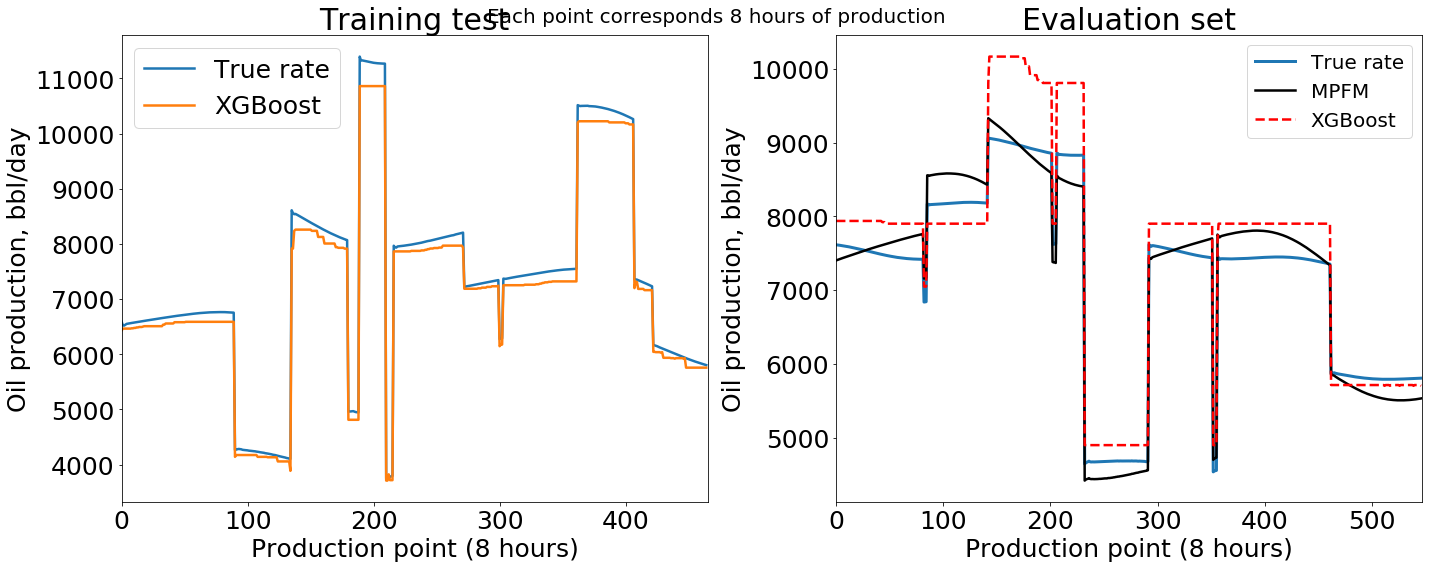

MAE XGBoost error in training is 157.30427148909203
MAPE MPFM error relative to truth in evaluation is 3.1449045880210322
MAPE XGBoost error relative to truth in training is 2.072522482551941
MAPE XGBoost error relative to truth in evaluation is 5.715744109505855


In [22]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error 
clf.fit(np.array(X_1_CV), np.array(y_1_CV))
predict_train = clf.predict(np.array(X_1_CV)) #Error on training set
predict_eval = clf.predict(np.array(X_2)) #Error on the evaluation set

#Plotting
#plot_importance(clf) #Can also plot feature importance for XGBoost
plot_function(y_true_train=y_1_CV, y_pred_train=predict_train, y_true_test=y_2_true, 
              y_MPFM_test=y_2, y_pred_test=predict_eval )

#Print the errors
print ('MAE XGBoost error in training is', mean_absolute_error(y_1_CV, predict_train))
print ('MAPE MPFM error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_2_true.values, y_2_meter.values))
print ('MAPE XGBoost error relative to truth in training is', \
       mean_absolute_percentage_error(y_1_CV, predict_train.reshape(y_1_CV.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is',\
       mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

### Early stopping

In [23]:
final_scores_random = np.array(output_stopping_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key = lambda column: column[2]), 
                           columns = ['mape_eval_stopping', 'mape_test_stopping', \
                                      'mape_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mape_eval_stopping,mape_test_stopping,mape_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,472.555729,428.376120,283.784728,34.0,6.0,9.547475,2.421177,6.0
1,435.585112,393.762159,318.534627,31.0,5.0,3.919192,12.343404,5.0
2,435.585112,393.762159,318.534627,26.0,3.0,13.969697,7.601143,1.0
3,435.585112,393.762159,318.534627,37.0,3.0,0.502020,17.139710,3.0
4,435.585112,393.762159,318.534627,37.0,4.0,16.582828,3.132639,3.0


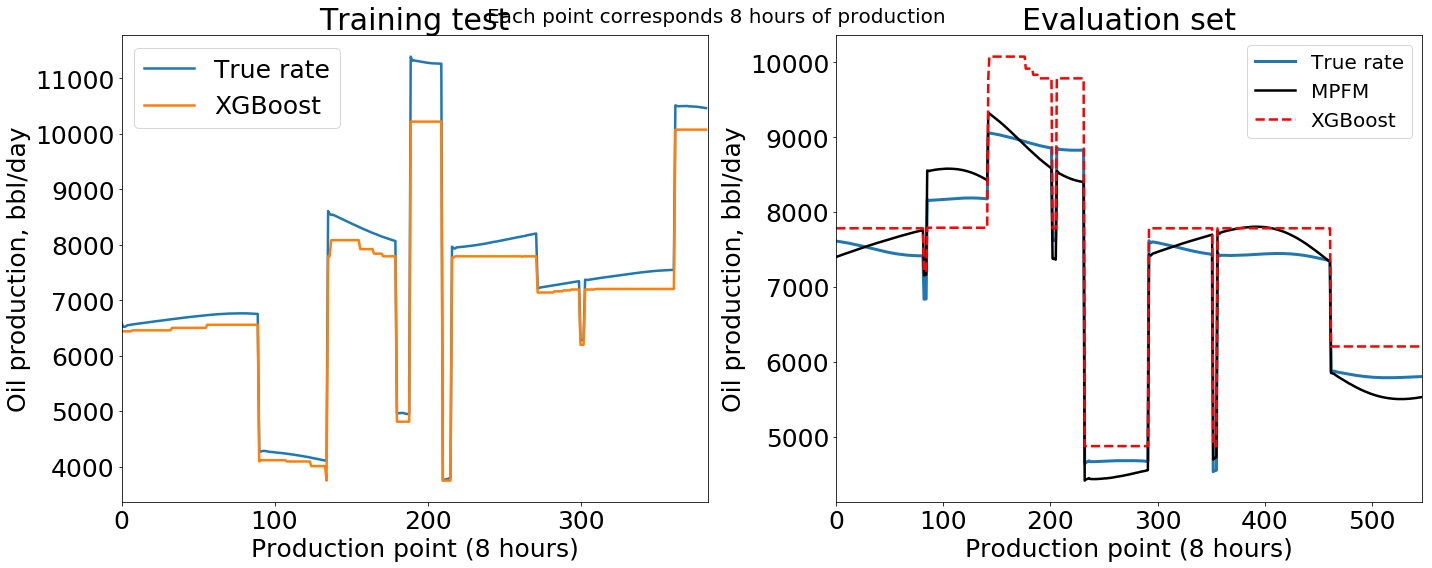

MAE XGBoost error in training is 274.72167246734284
MAPE XGBoost error in test set is 7.677494923916839
MAPE XGBoost error relative to truth in evaluation is 5.759877183087996


In [24]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], 
                       reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
#Checking the obtained error 
clf.fit(np.array(X_1_ES), np.array(y_1_ES))
predict_train = clf.predict(np.array(X_1_ES))
predict_test = clf.predict(np.array(X_1_test))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_1_ES, y_pred_train=predict_train, y_true_test=y_2_true, \
              y_MPFM_test=y_2, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', \
       mean_absolute_error(y_1_ES, predict_train))
print ('MAPE XGBoost error in test set is', \
       mean_absolute_percentage_error(y_1_test.values, predict_test.reshape(y_1_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

### Case 1.2

In [25]:
#Parameters for case 1.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 37 #37
MAX_DEPTH = 6

In [26]:
%%time
output_cv_2, output_stopping_2 = Random_search_selection(features_cv = X_2_CV, target_cv = y_2_CV, 
                                                         features_es = X_2_ES, target_es = y_2_ES, 
                                                         features_val = X_2_val, target_val = y_2_val, 
                                                         features_test = X_2_test, 
                                                         target_test = y_2_test, features_eval = X_3, 
                                                         target_eval = y_3,  
                                                         early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, 
                                                         learn_rate = RATE, fraction = FRACTION, 
                                                         max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5802.07
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:92.9777

[0]	validation_0-mae:5801.36
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:97.7042

[0]	validation_0-mae:5800.3
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	validation_0-mae:93.6993

[0]	validation_0-mae:5806.61
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	validation_0-mae:97.7389

[0]	validation_0-mae:5798.16
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:94.448

[0]	validation_0-mae:5801.72
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:95.8316

[0]	validation_0-mae:5822.58
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best i

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[37]	validation_0-mae:117.349

[0]	validation_0-mae:5799.94
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[27]	validation_0-mae:140.103

[0]	validation_0-mae:5810
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	validation_0-mae:93.6024

[0]	validation_0-mae:5824.01
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[33]	validation_0-mae:76.7711

[0]	validation_0-mae:5809.07
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:96.8107

[0]	validation_0-mae:5822.58
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	validation_0-mae:88.0211

[0]	validation_0-mae:5804.53
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-ma

### Cross validation

In [27]:
final_scores_random = np.array(output_cv_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,377.915300,150.715581,195.934983,36.0,7.0,6.934343,3.354099,2.0
1,310.175362,191.488236,238.652759,33.0,2.0,2.713131,11.119168,3.0
2,286.820322,202.053757,240.001854,33.0,1.0,2.914141,20.018091,4.0
3,303.380875,187.717593,243.445384,33.0,5.0,3.919192,11.725151,3.0
4,292.090386,178.920449,252.326707,33.0,5.0,5.929293,8.164649,3.0


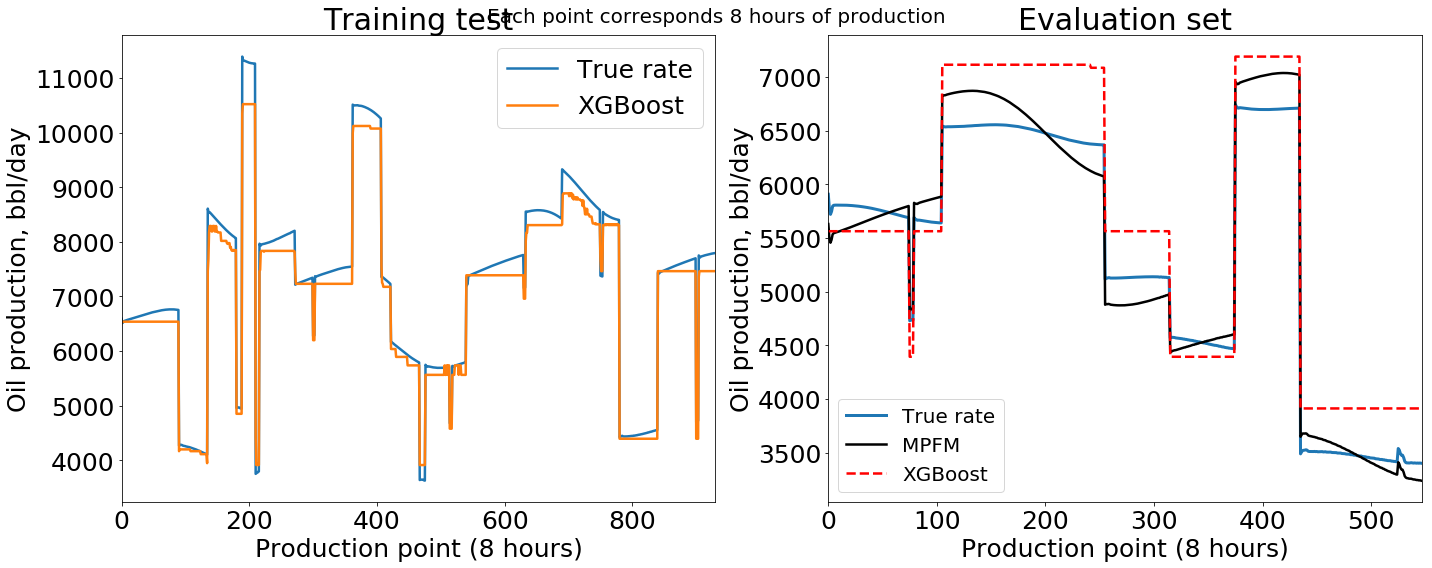

MAE XGBoost error in training is 195.93498338808718
MAPE MPFM error relative to truth in evaluation is 3.0910962571801877
MAPE XGBoost error relative to truth in training is 2.5852200212597256
MAPE XGBoost error relative to truth in evaluation is 7.90779582209604


In [28]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_2_CV), np.array(y_2_CV))
predict_train = clf.predict(np.array(X_2_CV))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_2_CV, y_pred_train=predict_train, y_true_test=y_3_true, \
              y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_CV, predict_train))
print ('MAPE MPFM error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_3_true.values, y_3_meter.values))
print ('MAPE XGBoost error relative to truth in training is', \
       mean_absolute_percentage_error(y_2_CV, predict_train.reshape(y_2_CV.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

### Early stopping

In [29]:
final_scores_random = np.array(output_stopping_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', \
                                      'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,362.18190,110.488713,328.586036,27.0,4.0,1.909091,3.132639,3.0
1,362.18190,110.488713,328.586036,25.0,7.0,18.391919,4.021846,3.0
2,362.18190,110.488713,328.586036,26.0,7.0,9.346465,7.603373,5.0
3,295.37995,94.974315,333.570697,25.0,1.0,16.180808,2.421177,2.0
4,295.37995,94.974315,333.570697,31.0,5.0,3.919192,12.343404,5.0


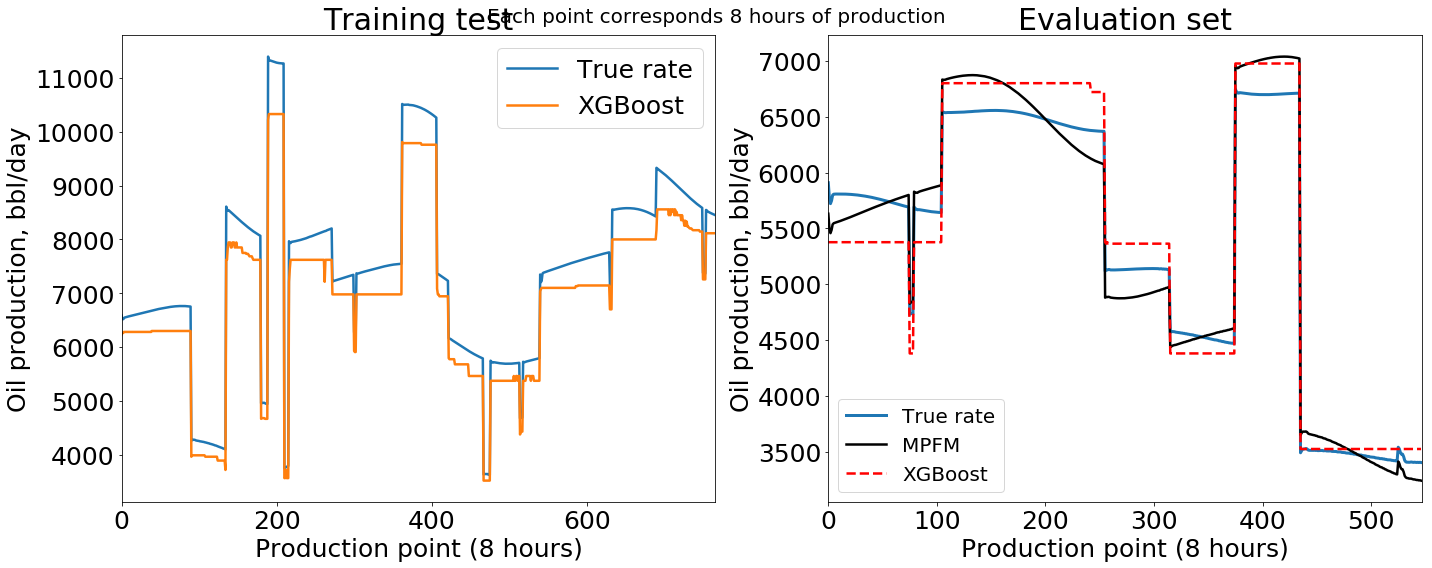

MAE XGBoost error in training is 448.94489397617394
MAPE XGBoost error in test set is 4.263041020584848
MAPE XGBoost error relative to truth in evaluation is 4.122121838731408


In [30]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_2_ES), np.array(y_2_ES))
predict_train = clf.predict(np.array(X_2_ES))
predict_test = clf.predict(np.array(X_2_test))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_2_ES, y_pred_train=predict_train, y_true_test=y_3_true, \
              y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_ES, predict_train))
print ('MAPE XGBoost error in test set is', \
       mean_absolute_percentage_error(y_2_test.values, predict_test.reshape(y_2_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

### Case 1.3

In [31]:
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [32]:
%%time
output_cv_3, output_stopping_3 = Random_search_selection(features_cv = X_3_CV, target_cv = y_3_CV, 
                                                         features_es = X_3_ES, target_es = y_3_ES, 
                                                         features_val = X_3_val, target_val = y_3_val, 
                                                         features_test = X_3_test, 
                                                         target_test = y_3_test, features_eval = X_4, 
                                                         target_eval = y_4,  
                                                         early_stopping_check = 'Yes',
                                                         error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, 
                                                         learn_rate = RATE, 
                                                         fraction = FRACTION, 
                                                         max_estim_num = MAX_ESTIM, 
                                                         depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5419.23
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:335.005

[0]	validation_0-mae:5418.78
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:338.043

[0]	validation_0-mae:5418.12
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:334.246

[0]	validation_0-mae:5410.89
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:330.601

[0]	validation_0-mae:5416.77
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:337.161

[0]	validation_0-mae:5419.01
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:337.929

[0]	validation_0-mae:5419.23
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:337.659

[0]	validation_0-mae:5417.89
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:329.432

[0]	validation_0-mae:5414.82
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[25]	validation_0-mae:326.445

[0]	validation_0-mae:5420.78
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:334.792

[0]	validation_0-mae:5422.76
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:336.795

[0]	validation_0-mae:5419.23
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:335.005

[0]	validation_0-mae:5421.66
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0

### Cross validation

In [33]:
final_scores_random = np.array(output_cv_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,369.271395,164.829119,186.222364,36.0,5.0,11.959596,16.424495,5.0
1,421.788556,248.101118,199.575763,34.0,2.0,1.306061,18.714578,4.0
2,275.947359,195.923839,233.710326,33.0,5.0,5.929293,8.164649,3.0
3,322.611456,392.817800,280.386657,32.0,5.0,13.366667,14.893674,2.0
4,391.887419,245.887517,295.993720,30.0,7.0,0.502020,19.074765,3.0


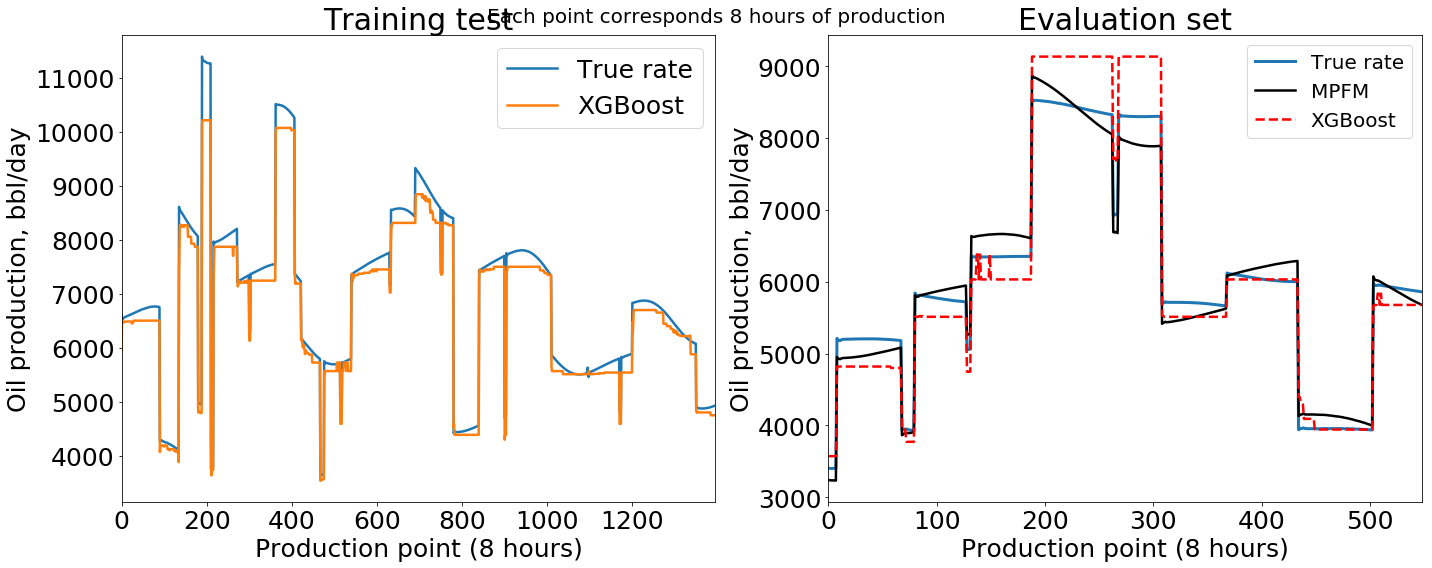

MAE XGBoost error in training is 186.22236418746735
MAPE MPFM error relative to truth in evaluation is 3.1380069558666146
MAPE XGBoost error relative to truth in training is 2.5655677470042977
MAPE XGBoost error relative to truth in evaluation is 4.7225647048506065


In [34]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], 
                       reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV), np.array(y_3_CV))
predict_train = clf.predict(np.array(X_3_CV))

#Computing the error on the evaluation set
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_CV, y_pred_train=predict_train, y_true_test=y_4_true, \
              y_MPFM_test=y_4, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_CV, predict_train))
print ('MAPE MPFM error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_4_true.values, y_4_meter.values))
print ('MAPE XGBoost error relative to truth in training is', \
       mean_absolute_percentage_error(y_3_CV, predict_train.reshape(y_3_CV.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

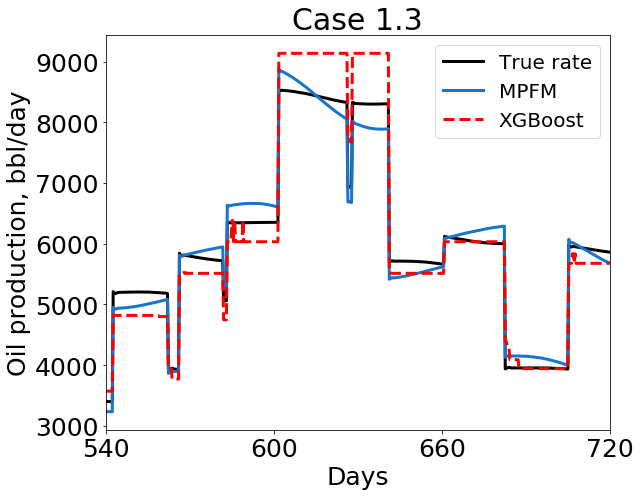

In [35]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV), np.array(y_3_CV))
predict_train = clf.predict(np.array(X_3_CV))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plt.figure(figsize = (9, 7))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(np.array(y_4_true), label = 'True rate', linewidth = 3, color = 'k')
ax2.plot(np.array(y_4), label = 'MPFM', linewidth = 3, color = '#1874CD')
ax2.plot(predict_eval, label = 'XGBoost', linewidth = 3, linestyle = '--', color = 'r')
ax2.legend(fontsize = 20)
ax2.set_title('Case 1.3', size = 30)

#x-axis
ax2.set_xlabel('Days', size = 25)
ax2.set_xlim(0, 547.5)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
x_values = [0, 540, 600, 660, 720]
plt.gca().xaxis.set_ticklabels(x_values, size = 25)

#y-axis
ax2.set_ylabel('Oil production, bbl/day', size = 25)
ax2.yaxis.set_tick_params(labelsize = 25)
plt.tight_layout()

plt.savefig('Case_1.3.jpg', dpi=1200, format = 'jpg')

### Early stopping

In [36]:
final_scores_random = np.array(output_stopping_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', \
                                      'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,342.657259,215.957113,462.185926,37.0,3.0,0.502020,17.139710,3.0
1,342.657259,215.957113,462.185926,37.0,4.0,16.582828,3.132639,3.0
2,342.657259,215.957113,462.185926,25.0,7.0,18.391919,4.021846,3.0
3,342.657259,215.957113,462.185926,26.0,7.0,9.346465,7.603373,5.0
4,342.657259,215.957113,462.185926,32.0,2.0,3.919192,9.128223,1.0


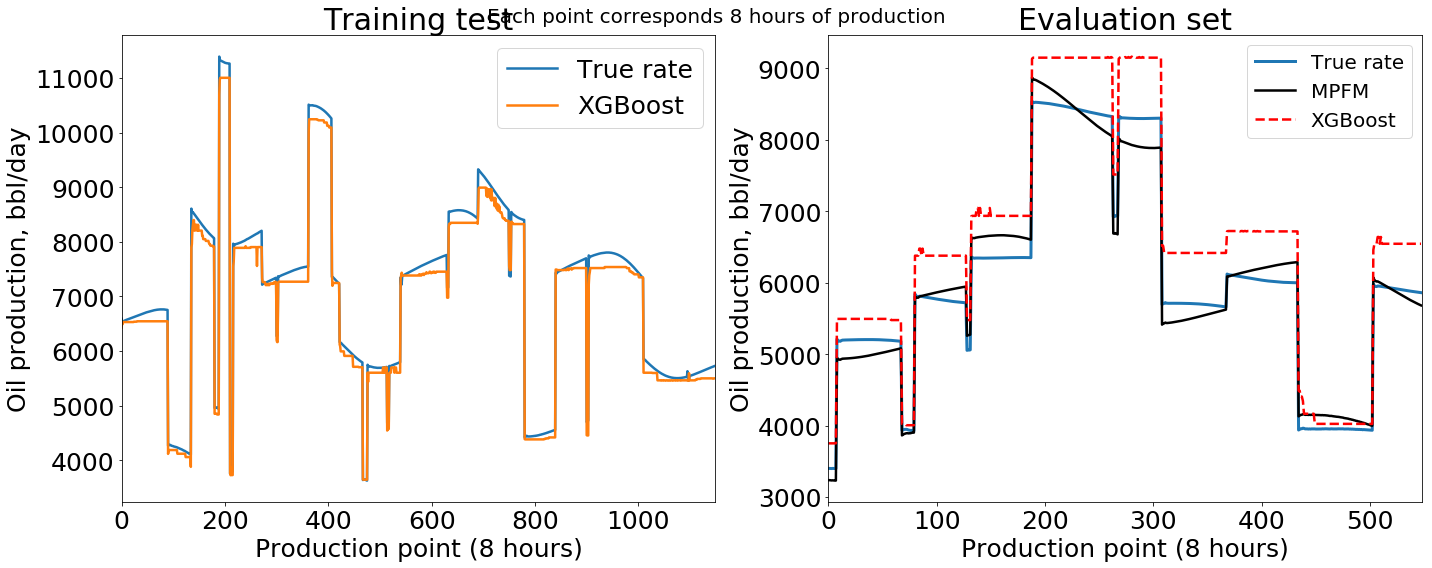

MAE XGBoost error in training is 149.0487462336705
MAPE XGBoost error in test set is 4.961081391494746
MAPE XGBoost error relative to truth in evaluation is 8.756313590002545


In [37]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_3_ES), np.array(y_3_ES))
predict_train = clf.predict(np.array(X_3_ES))
predict_test = clf.predict(np.array(X_3_test))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_ES, y_pred_train=predict_train, y_true_test=y_4_true, \
              y_MPFM_test=y_4, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_ES, predict_train))
print ('MAPE XGBoost error in test set is', \
       mean_absolute_percentage_error(y_3_test.values, predict_test.reshape(y_3_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

## Case 2

### Case 2.1

In [38]:
#Parameters for case 1.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [39]:
%%time
output_cv_1, output_stopping_1 = Random_search_selection(features_cv = X_1_CV_2, target_cv = y_1_CV_2, 
                                                         features_es = X_1_ES_2, target_es = y_1_ES_2, 
                                                         features_val = X_1_val, target_val = y_1_val, 
                                                         features_test = X_1_test, target_test = y_1_test, 
                                                         features_eval = X_2, 
                                                         target_eval = y_2,  
                                                         early_stopping_check = 'Yes', 
                                                         error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, 
                                                         learn_rate = RATE, fraction = FRACTION, 
                                                         max_estim_num = MAX_ESTIM, 
                                                         depth_limit = MAX_DEPTH)

[0]	validation_0-mae:6689.39
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[44]	validation_0-mae:174.996

[0]	validation_0-mae:6688.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:145.529

[0]	validation_0-mae:6687.63
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:155.936

[0]	validation_0-mae:6676.2
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[42]	validation_0-mae:216.694

[0]	validation_0-mae:6704.44
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[38]	validation_0-mae:249.069

[0]	validation_0-mae:6689.04
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[43]	validation_0-mae:157.77

[0]	validation_0-mae:6689.39
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best i

Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:196.008
Stopping. Best iteration:
[46]	validation_0-mae:189.644

[0]	validation_0-mae:6724.54
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[28]	validation_0-mae:466.024

[0]	validation_0-mae:6691.13
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:215.578
Stopping. Best iteration:
[46]	validation_0-mae:206.085

[0]	validation_0-mae:6651.39
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[36]	validation_0-mae:155.402

[0]	validation_0-mae:6687.28
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:390.051
Stopping. Best iteration:
[48]	validation_0-mae:386.738

[0]	validation_0-mae:6726.51
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:82.5398
Stopping. Best iteration:
[49]	validation_0-mae:82.0167

[0]	validation_

### Cross-validation

In [40]:
final_scores_random = np.array(output_cv_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,165.524571,48.297805,164.497612,38.0,3.0,3.517172,1.211411,5.0
1,206.696991,75.933758,170.707541,39.0,3.0,6.934343,3.234222,3.0
2,167.728956,44.476900,188.138575,36.0,7.0,1.909091,12.967298,5.0
3,164.360105,43.032118,190.834424,37.0,6.0,5.929293,5.077554,5.0
4,133.517907,52.060116,192.808312,36.0,5.0,2.512121,17.435145,3.0


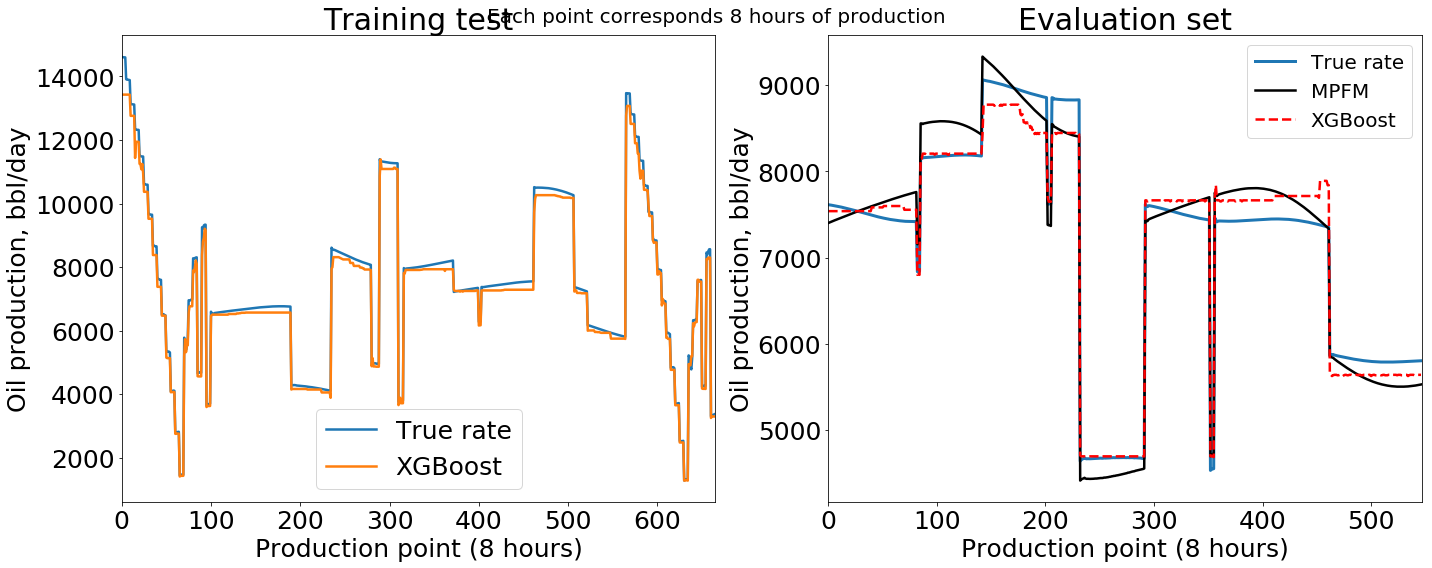

MAE XGBoost error in training is 164.497612222946
MAPE XGBoost error relative to truth in training is 2.1129091707704
MAPE XGBoost error relative to truth in evaluation is 2.272108451783443


In [41]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], 
                       reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_1_CV_2), np.array(y_1_CV_2))
predict_train = clf.predict(np.array(X_1_CV_2))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_1_CV_2, y_pred_train=predict_train, y_true_test=y_2_true, \
              y_MPFM_test=y_2, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_CV_2, predict_train))
print ('MAPE XGBoost error relative to truth in training is', \
       mean_absolute_percentage_error(y_1_CV_2, predict_train.reshape(y_1_CV_2.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

### Early stopping

In [42]:
final_scores_random = np.array(output_stopping_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', 'mae_train_stopping', \
                                      'n_estimators', 'min_child_weight', 'reg_lambda', \
                                      'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,159.868160,160.668457,62.362700,36.0,6.0,1.909091,18.953031,4.0
1,159.868160,160.668457,62.362700,31.0,3.0,17.989899,17.056875,3.0
2,172.398255,168.789682,70.707656,37.0,3.0,0.502020,17.139710,3.0
3,172.398255,168.789682,70.707656,37.0,4.0,16.582828,3.132639,3.0
4,172.398255,168.789682,70.707656,25.0,7.0,18.391919,4.021846,3.0


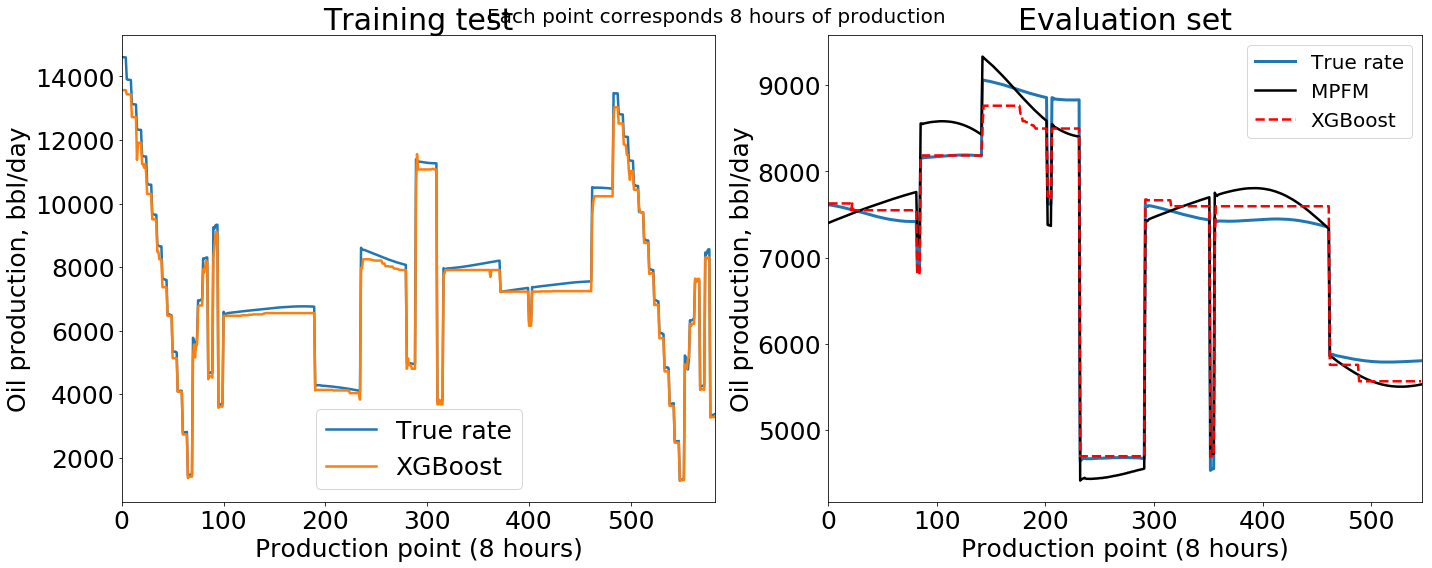

MAE XGBoost error in training is 189.76255637556247
MAPE XGBoost error in test set is 1.0553244124097185
MAPE XGBoost error relative to truth in evaluation is 1.8782548559441417


In [43]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, \
                       n_estimators = int(final_score['n_estimators'][0]), \
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), \
                       min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_1_ES_2), np.array(y_1_ES_2))
predict_train = clf.predict(np.array(X_1_ES_2))
predict_test = clf.predict(np.array(X_1_test))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_1_ES_2, y_pred_train=predict_train, y_true_test=y_2_true, \
              y_MPFM_test=y_2, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_ES_2, predict_train))
print ('MAPE XGBoost error in test set is', \
       mean_absolute_percentage_error(y_1_test.values, predict_test.reshape(y_1_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

### Case 2.2

In [44]:
#Parameters for case 2.2
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [45]:
%%time
output_cv_2, output_stopping_2 = Random_search_selection(features_cv = X_2_CV, target_cv = y_2_CV, 
                                                         features_es = X_2_ES, target_es = y_2_ES, 
                                                         features_val = X_2_val, target_val = y_2_val, 
                                                         features_test = X_2_test, 
                                                         target_test = y_2_test, features_eval = X_3, 
                                                         target_eval = y_3,  
                                                         early_stopping_check = 'Yes', 
                                                         error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, 
                                                         learn_rate = RATE, 
                                                         fraction = FRACTION, 
                                                         max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5802.07
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:92.9777

[0]	validation_0-mae:5801.36
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:97.7042

[0]	validation_0-mae:5800.3
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	validation_0-mae:93.6993

[0]	validation_0-mae:5825.01
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	validation_0-mae:88.0501

[0]	validation_0-mae:5798.16
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:94.448

[0]	validation_0-mae:5801.72
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:95.8316

[0]	validation_0-mae:5802.07
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best i

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[37]	validation_0-mae:117.349

[0]	validation_0-mae:5799.94
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[27]	validation_0-mae:140.103

[0]	validation_0-mae:5843.95
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[35]	validation_0-mae:97.3437

[0]	validation_0-mae:5804.53
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	validation_0-mae:90.8551

[0]	validation_0-mae:5809.07
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:96.8107

[0]	validation_0-mae:5802.07
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:92.9777

[0]	validation_0-mae:5805.92
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	validation_0

### Cross-validation

In [46]:
final_scores_random = np.array(output_cv_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mape_eval', 'mape_test', 'mape_train', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mape_eval,mape_test,mape_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,349.329820,141.806179,144.864975,39.0,3.0,6.934343,3.234222,3.0
1,340.896334,141.113098,152.221317,38.0,3.0,4.321212,17.141196,3.0
2,314.704546,139.724382,171.963836,37.0,6.0,5.929293,5.077554,5.0
3,344.902117,138.139748,174.561385,36.0,7.0,1.909091,12.967298,5.0
4,325.060957,156.676239,210.510337,34.0,2.0,1.306061,18.714578,4.0


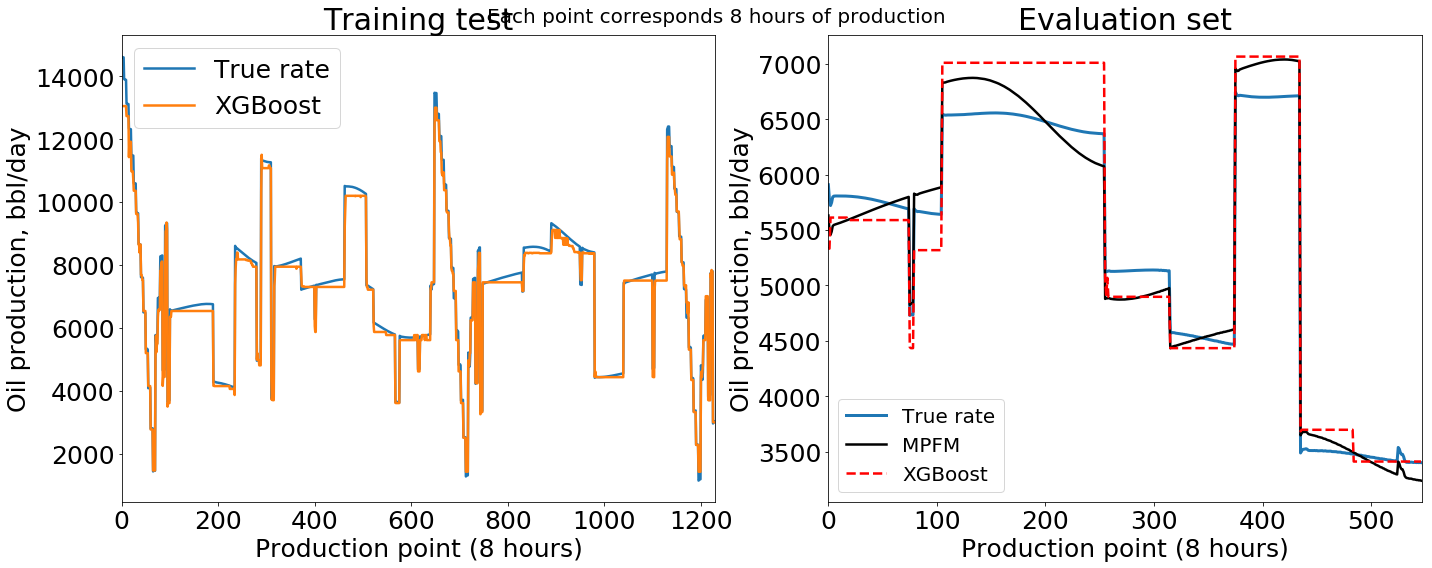

MAE error in training is 161.1680783155314
MAPE error in training is 2.1966803842347007
MAPE error with truth is 4.849628907324967


In [47]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_2_CV_2), np.array(y_2_CV_2))
predict_train = clf.predict(np.array(X_2_CV_2))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_2_CV_2, y_pred_train=predict_train, y_true_test=y_3_true, \
              y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE error in training is', mean_absolute_error(y_2_CV_2, predict_train))
print ('MAPE error in training is', \
       mean_absolute_percentage_error(y_2_CV_2, predict_train.reshape(y_2_CV_2.shape[0], 1)))
print ('MAPE error with truth is', \
       mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

### Early stopping

In [48]:
final_scores_random = np.array(output_stopping_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', 'mae_train_stopping', \
                                      'n_estimators', 'min_child_weight', 'reg_lambda', \
                                      'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,293.953283,97.248396,331.578244,25.0,1.0,16.180808,2.421177,2.0
1,293.953283,97.248396,331.578244,31.0,5.0,3.919192,12.343404,5.0
2,293.953283,97.248396,331.578244,26.0,3.0,13.969697,7.601143,1.0
3,293.953283,97.248396,331.578244,37.0,3.0,0.502020,17.139710,3.0
4,293.953283,97.248396,331.578244,37.0,4.0,16.582828,3.132639,3.0


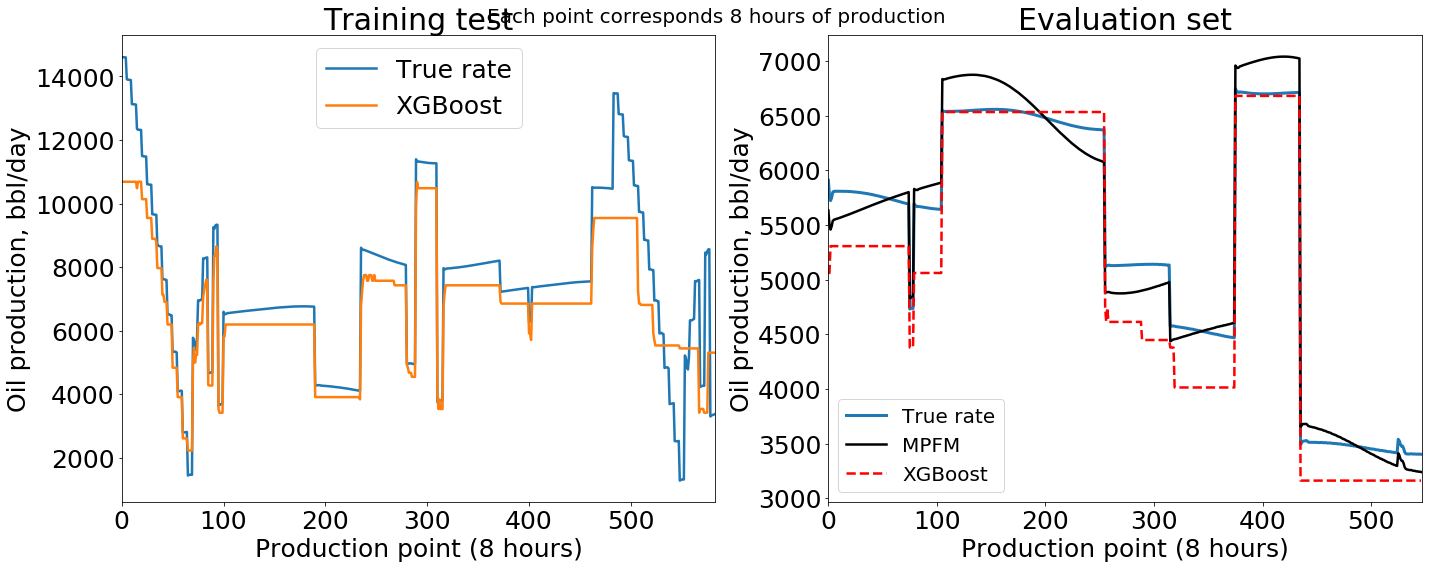

MAE XGBoost error in training is 644.965367857548
MAPE XGBoost error in test set is 5.919748597621799
MAPE XGBoost error relative to truth in evaluation is 6.198943466796135


In [49]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_2_ES_2), np.array(y_2_ES_2))
predict_train = clf.predict(np.array(X_2_ES_2))
predict_test = clf.predict(np.array(X_2_test))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_1_ES_2, y_pred_train=predict_train, y_true_test=y_3_true, \
              y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_ES_2, predict_train))
print ('MAPE XGBoost error in test set is', \
       mean_absolute_percentage_error(y_2_test.values, predict_test.reshape(y_2_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

### Case 2.3

In [50]:
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [51]:
%%time
output_cv_3, output_stopping_3 = Random_search_selection(features_cv = X_3_CV, target_cv = y_3_CV, 
                                                         features_es = X_3_ES, target_es = y_3_ES, 
                                                         features_val = X_3_val, target_val = y_3_val, 
                                                         features_test = X_3_test, target_test = y_3_test, 
                                                         features_eval = X_4, target_eval = y_4,  
                                                         early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, 
                                                         learn_rate = RATE, fraction = FRACTION, 
                                                         max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5419.23
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:335.005

[0]	validation_0-mae:5418.78
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:338.043

[0]	validation_0-mae:5418.12
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:334.246

[0]	validation_0-mae:5410.89
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:330.601

[0]	validation_0-mae:5416.77
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:337.161

[0]	validation_0-mae:5419.01
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:337.929

[0]	validation_0-mae:5419.23
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:337.659

[0]	validation_0-mae:5417.89
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:329.432

[0]	validation_0-mae:5414.82
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[25]	validation_0-mae:326.445

[0]	validation_0-mae:5420.78
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:334.792

[0]	validation_0-mae:5422.76
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:336.795

[0]	validation_0-mae:5419.23
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:335.005

[0]	validation_0-mae:5421.66
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0

In [52]:
final_scores_random = np.array(output_cv_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mape_eval', 'mape_test', 'mape_train', 'n_estimators',\
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mape_eval,mape_test,mape_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,369.271395,164.829119,186.222364,36.0,5.0,11.959596,16.424495,5.0
1,421.788556,248.101118,199.575763,34.0,2.0,1.306061,18.714578,4.0
2,275.947359,195.923839,233.710326,33.0,5.0,5.929293,8.164649,3.0
3,322.611456,392.817800,280.386657,32.0,5.0,13.366667,14.893674,2.0
4,391.887419,245.887517,295.993720,30.0,7.0,0.502020,19.074765,3.0


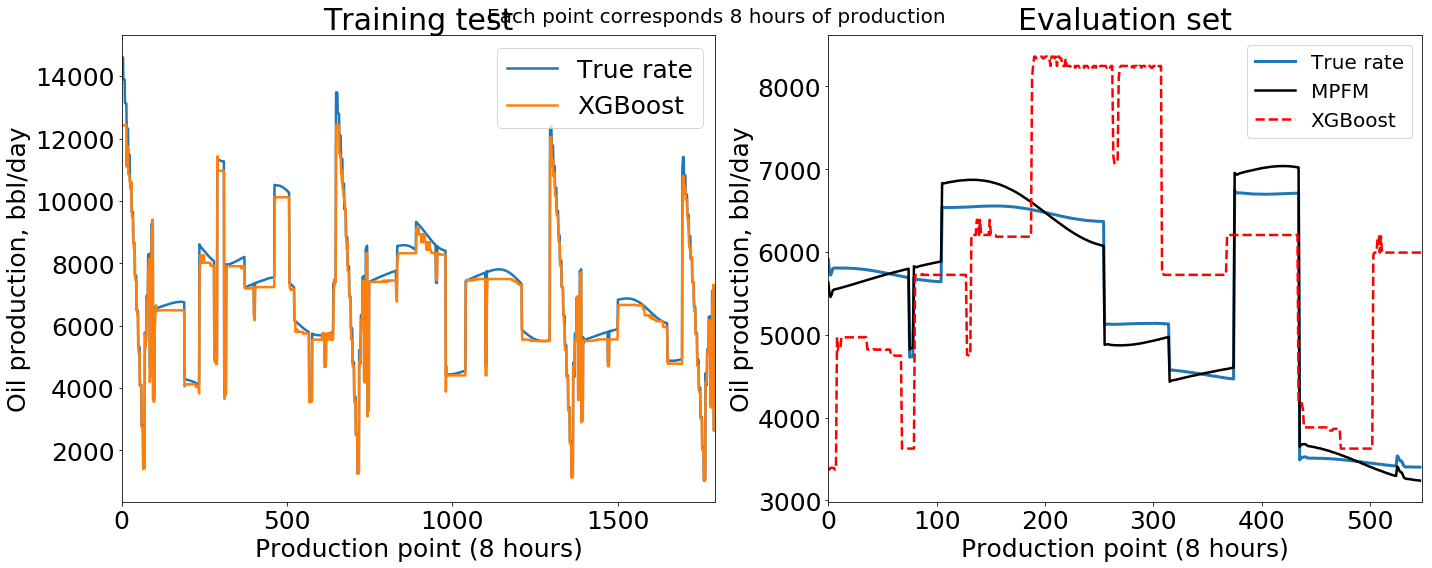

MAE XGBoost error in training is 197.75274611455927
MAPE XGBoost error relative to truth in training is 2.693239735494565
MAPE XGBoost error relative to truth in evaluation is 2.680006993342908


In [53]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV_2), np.array(y_3_CV_2))
predict_train = clf.predict(np.array(X_3_CV_2))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_CV_2, y_pred_train=predict_train, y_true_test=y_3_true, \
              y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_CV_2, predict_train))
print ('MAPE XGBoost error relative to truth in training is', \
       mean_absolute_percentage_error(y_3_CV_2, predict_train.reshape(y_3_CV_2.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

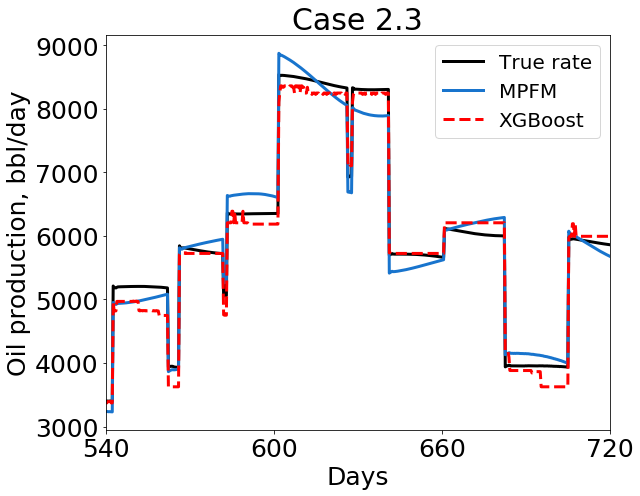

In [54]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV_2), np.array(y_3_CV_2))
predict_train = clf.predict(np.array(X_3_CV_2))
predict_eval = clf.predict(np.array(X_4))
#Plotting
plt.figure(figsize = (9, 7))

ax2 = plt.subplot(1, 1, 1)
ax2.plot(np.array(y_4_true), label = 'True rate', linewidth = 3, color = 'k')
ax2.plot(np.array(y_4), label = 'MPFM', linewidth = 3, color = '#1874CD')
ax2.plot(predict_eval, label = 'XGBoost', linewidth = 3, linestyle = '--', color = 'r')
ax2.legend(fontsize = 20)
ax2.set_title('Case 2.3', size = 30)

#x-axis
ax2.set_xlabel('Days', size = 25)
ax2.set_xlim(0, 547.5)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
x_values = [0, 540, 600, 660, 720]
plt.gca().xaxis.set_ticklabels(x_values, size = 25)

#y-axis
ax2.set_ylabel('Oil production, bbl/day', size = 25)
ax2.yaxis.set_tick_params(labelsize = 25)
plt.tight_layout()

#plt.savefig('Case_2.3.eps', dpi=1200, format = 'eps')

### Early stopping

In [55]:
final_scores_random = np.array(output_stopping_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', \
                                      'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,342.657259,215.957113,462.185926,37.0,3.0,0.502020,17.139710,3.0
1,342.657259,215.957113,462.185926,37.0,4.0,16.582828,3.132639,3.0
2,342.657259,215.957113,462.185926,25.0,7.0,18.391919,4.021846,3.0
3,342.657259,215.957113,462.185926,26.0,7.0,9.346465,7.603373,5.0
4,342.657259,215.957113,462.185926,32.0,2.0,3.919192,9.128223,1.0


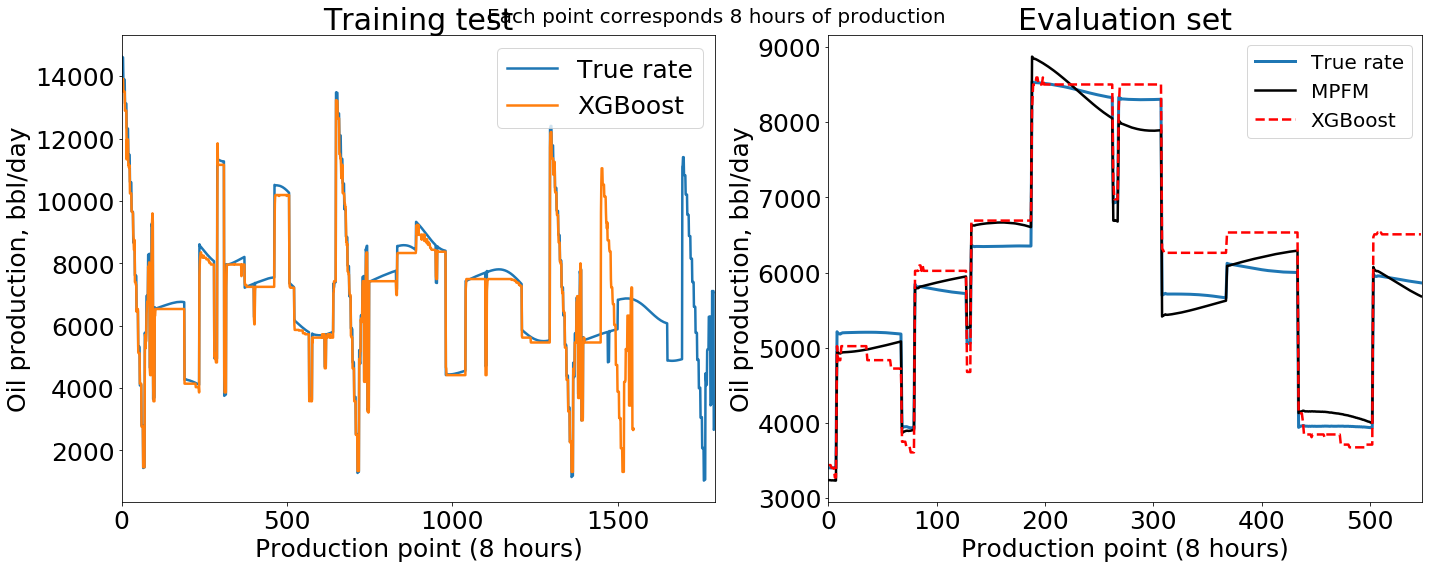

MAE XGBoost error in training is 166.72896165283083
MAPE XGBoost error in test set is 3.658574237287283
MAPE XGBoost error relative to truth in evaluation is 5.5620504359195015


In [56]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_3_ES_2), np.array(y_3_ES_2))
predict_train = clf.predict(np.array(X_3_ES_2))
predict_test = clf.predict(np.array(X_3_test))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_CV_2, y_pred_train=predict_train, y_true_test=y_4_true, \
              y_MPFM_test=y_4, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_ES_2, predict_train))
print ('MAPE XGBoost error in test set is', \
       mean_absolute_percentage_error(y_3_test.values, predict_test.reshape(y_3_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

## Case 3

### Case 3.1

In [57]:
#Parameters for case 3.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 80
MAX_DEPTH = 6

In [58]:
%%time
output_1 = Random_search_selection(features_cv = X_1_train, target_cv = y_1_train, 
                                   features_es = [], target_es = [], features_val = [], 
                                   target_val = [], features_test = X_1_train, 
                                   target_test = y_1_train, features_eval = X_1, target_eval = y_1, 
                                   early_stopping_check = None, error_type = 'mae', 
                                   num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                   fraction = FRACTION, max_estim_num = MAX_ESTIM, 
                                   depth_limit = MAX_DEPTH)

Wall time: 733 ms


In [59]:
final_scores_random = np.array(output_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train','n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,478.213752,12.789120,12.789120,78.0,2.0,1.306061,2.682286,3.0
1,466.858262,28.747083,28.747083,56.0,5.0,0.301010,6.248464,5.0
2,482.196258,30.726959,30.726959,78.0,7.0,0.502020,19.074765,3.0
3,429.331116,33.069792,33.069792,70.0,3.0,4.321212,17.141196,3.0
4,438.503421,34.035705,34.035705,68.0,1.0,2.914141,11.579121,2.0


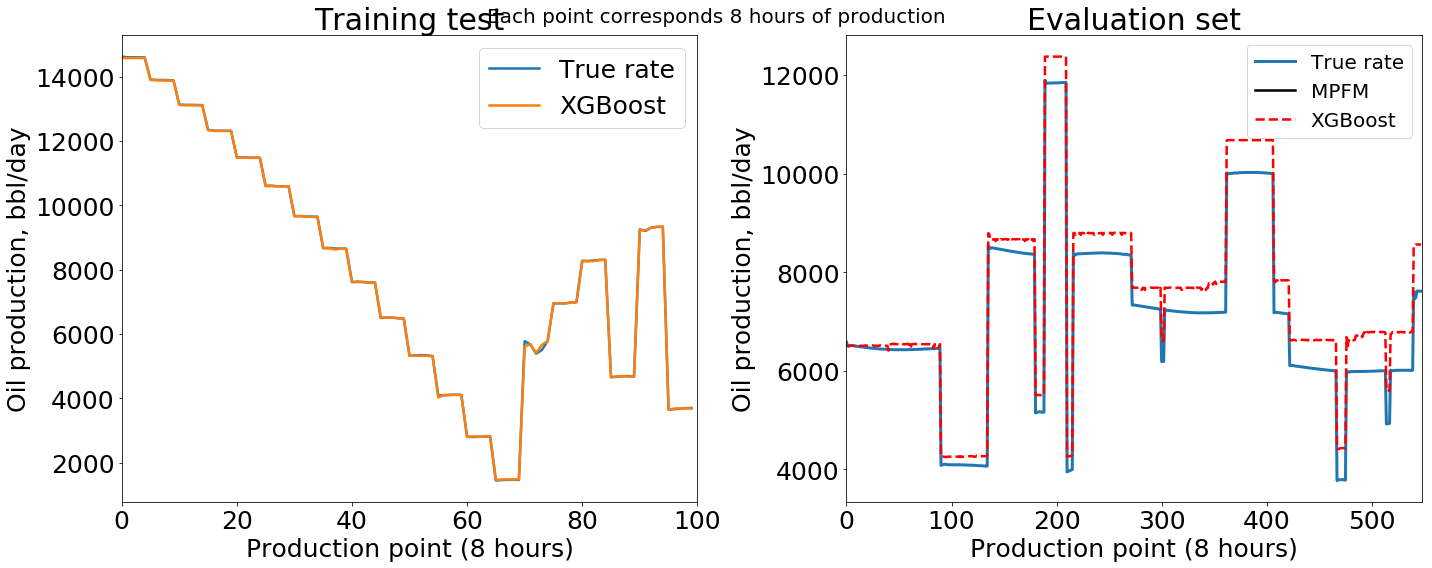

MAE XGBoost error in training is 12.789119770316699
MAPE XGBoost error relative to truth in evaluation is 7.147907865287824


In [60]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_1_train), np.array(y_1_train))
predict_train = clf.predict(np.array(X_1_train))
predict_eval = clf.predict(np.array(X_1))

#Plotting
plot_function(y_true_train=y_1_train, y_pred_train=predict_train, \
              y_true_test=y_1_true, y_MPFM_test=[], y_pred_test=predict_eval)
#plt.savefig('Case_3_OF.jpg', dpi=1200, format='jpg')

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_1.values, predict_eval.reshape(y_1.shape[0], 1)))

### Case 3.2

In [61]:
#Parameters for case 3.2
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 80 #AF -40, OF- 60
MAX_DEPTH = 6

In [62]:
%%time
output_2 = Random_search_selection(features_cv = X_2_train, target_cv = y_2_train, features_es = [], 
                                   target_es = [], features_val = [], target_val = [], 
                                   features_test = X_2_train, target_test = y_2_train, 
                                   features_eval = X_2, target_eval = y_2, 
                                   early_stopping_check = None, error_type = 'mae', 
                                   num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                   fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 1.21 s


In [63]:
final_scores_random = np.array(output_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,209.586307,32.060094,32.060094,63.0,3.0,0.703030,10.926656,4.0
1,144.659728,34.751323,34.751323,56.0,5.0,0.301010,6.248464,5.0
2,210.676742,40.356230,40.356230,78.0,6.0,3.316162,8.537982,5.0
3,145.771671,40.677004,40.677004,78.0,7.0,0.502020,19.074765,3.0
4,345.701799,55.003235,55.003235,48.0,4.0,0.100000,5.624777,5.0


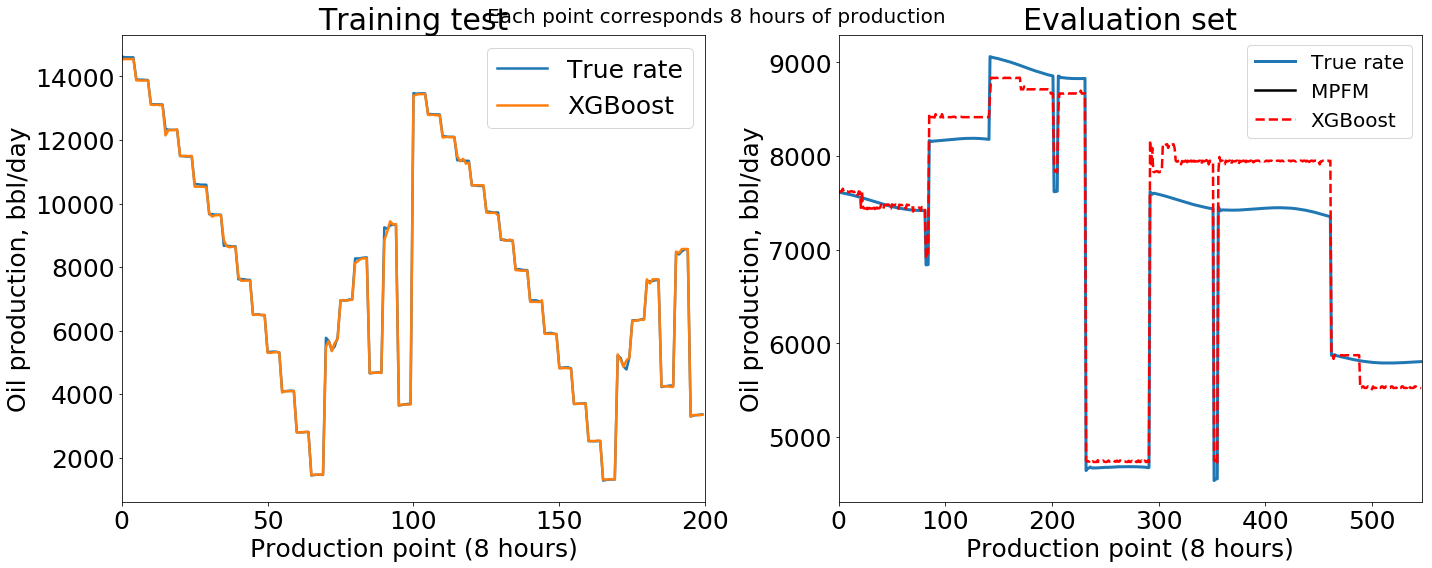

MAE XGBoost error in training is 32.060094367687384
MAPE XGBoost error relative to truth in evaluation is 2.987913233153454


In [64]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, \
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), \
                       min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_2_train), np.array(y_2_train))
predict_train = clf.predict(np.array(X_2_train))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_2_train, y_pred_train=predict_train, y_true_test=y_2_true, \
              y_MPFM_test=[], y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_2.values, predict_eval.reshape(y_2.shape[0], 1)))

### Case 3.3

In [65]:
#Parameters for case 3.3
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 95
MAX_DEPTH = 6

In [66]:
%%time
output_3 = Random_search_selection(features_cv = X_3_train, target_cv = y_3_train, features_es = [], 
                                   target_es = [], features_val = [], target_val = [], 
                                   features_test = X_3_train, target_test = y_3_train, 
                                   features_eval = X_3, target_eval = y_3, 
                                   early_stopping_check = None, error_type = 'mae', 
                                   num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                   fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 1.71 s


In [67]:
final_scores_random = np.array(output_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,176.783558,27.802729,27.802729,89.0,5.0,1.105051,11.643134,5.0
1,168.703372,32.957484,32.957484,70.0,4.0,0.703030,15.397973,4.0
2,169.671343,33.120267,33.120267,80.0,4.0,2.512121,16.652645,5.0
3,172.007697,40.395590,40.395590,79.0,3.0,1.909091,14.498979,4.0
4,175.533218,48.054744,48.054744,64.0,6.0,1.507071,11.133147,4.0


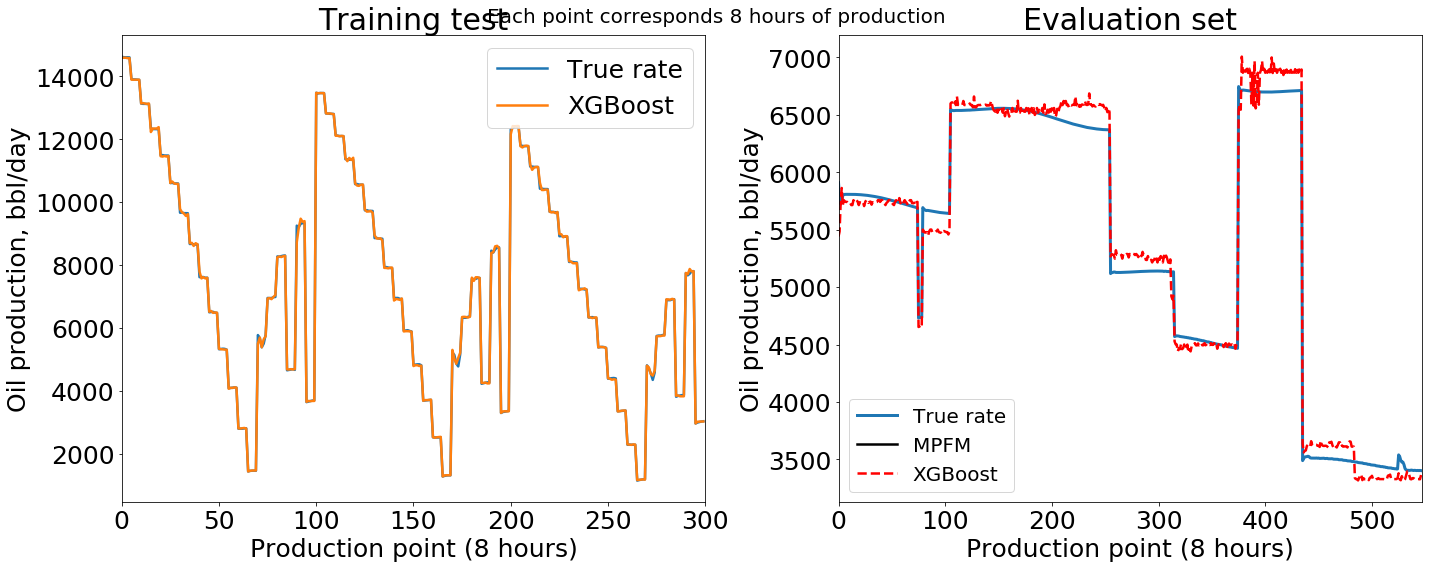

MAE XGBoost error in training is 27.802729047304886
MAPE XGBoost error relative to truth in evaluation is 3.1627700371904286


In [68]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_3_train), np.array(y_3_train))
predict_train = clf.predict(np.array(X_3_train))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_3_train, y_pred_train=predict_train, \
              y_true_test=y_3_true, y_MPFM_test=[], y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_3.values, predict_eval.reshape(y_3.shape[0], 1)))

### Case 3.4

In [69]:
#Parameters for case 3.4
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 80
MAX_DEPTH = 6

In [70]:
%%time
output_4 = Random_search_selection(features_cv = X_4_train, target_cv = y_4_train, features_es = [], 
                                   target_es = [], features_val = [], target_val = [],
                                   features_test = X_4_train, target_test = y_4_train, 
                                   features_eval = X_4, target_eval = y_4, 
                                   early_stopping_check = None, error_type = 'mae', 
                                   num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                   fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 1.93 s


In [71]:
final_scores_random = np.array(output_4).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval','mae_test', 'mae_train', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,226.855279,41.058926,41.058926,56.0,5.0,0.301010,6.248464,5.0
1,270.701127,46.419458,46.419458,63.0,3.0,0.703030,10.926656,4.0
2,261.465807,56.282391,56.282391,48.0,4.0,0.100000,5.624777,5.0
3,282.458683,56.764472,56.764472,78.0,6.0,3.316162,8.537982,5.0
4,274.690771,59.771508,59.771508,78.0,7.0,0.502020,19.074765,3.0


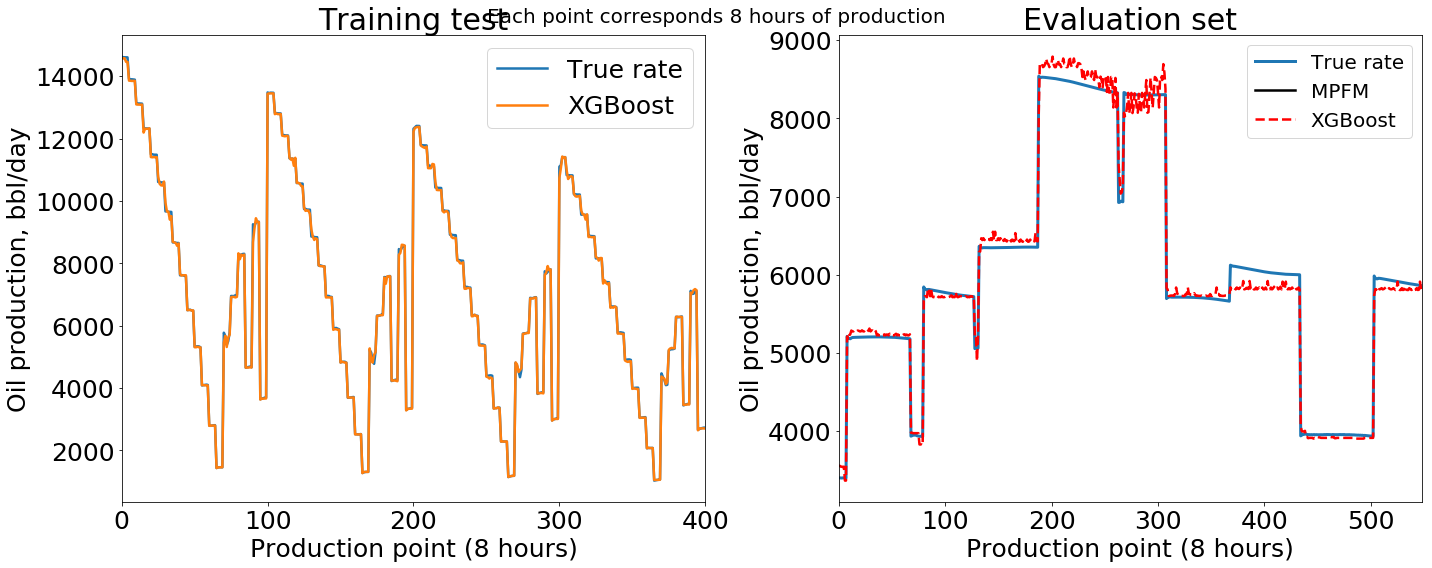

MAE XGBoost error in training is 41.05892646564026
MAPE XGBoost error relative to truth in evaluation is 3.888121557869066


In [72]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, 
                       n_estimators = int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), 
                       min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_4_train), np.array(y_4_train))
predict_train = clf.predict(np.array(X_4_train))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_4_train, y_pred_train=predict_train, y_true_test=y_4_true, \
              y_MPFM_test=[], y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_4_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', \
       mean_absolute_percentage_error(y_4.values, predict_eval.reshape(y_4.shape[0], 1)))